<a href="https://colab.research.google.com/github/Karasiari/Graphs/blob/main/MultiApproachMCFwith.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
%pip install "git+https://github.com/Karasiari/graphmcf.git"

  Cloning https://github.com/Karasiari/graphmcf.git to /tmp/pip-req-build-mrjzctvm
  Running command git clone --filter=blob:none --quiet https://github.com/Karasiari/graphmcf.git /tmp/pip-req-build-mrjzctvm
  Resolved https://github.com/Karasiari/graphmcf.git to commit 1fd1e779139c269c68e00b95fe9b6dafa0e82e9c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for graphmcf: filename=graphmcf-0.1.0-py3-none-any.whl size=46766 sha256=8129d38ecac26a382ce6623f5c80f2aae69d4346ff8e54a343f7076de549f305
  Stored in directory: /tmp/pip-ephem-wheel-cache-adq5t1x_/wheels/e2/0b/c2/f959f38e6d22c15057366b9e17b9295eb9dfc85fd11eff7962
Successfully built graphmcf


In [2]:
import numpy as np

import cvxpy as cp
import networkx as nx

from dataclasses import dataclass
from typing import Optional

@dataclass(frozen=True)
class Solution:
    problem: cp.Problem
    flow: np.ndarray
    add_bandwidth: Optional[np.ndarray] = None
    gamma: Optional[float] = None
    traffic_mat: Optional[float] = None

    def to_vector(self) -> np.ndarray:
        sol_parts = [self.flow.T.flatten()]
        if self.add_bandwidth is not None:
            sol_parts.append(self.add_bandwidth)
        if self.gamma is not None:
            sol_parts.append(self.gamma)
        return np.hstack(sol_parts)


def vector_to_solution(graph: nx.DiGraph, vec: np.ndarray, problem_type: str):
    m, n = graph.number_of_edges(), graph.number_of_nodes()
    flow = vec[: m * n].reshape(n, m).T
    add_bandwidth = None
    gamma = None
    if problem_type in ["opt_network_min_cost_concurrent_flow", "opt_network_max_concurrent_flow"]:
        add_bandwidth = vec[m * n : m * n + m]
    if problem_type in ["max_concurrent_flow", "opt_network_max_concurrent_flow"]:
        gamma = vec[-1]
    return Solution(problem=None, flow=flow, add_bandwidth=add_bandwidth, gamma=gamma)

# Вспомогательные

def get_incidence_matrix(graph: nx.DiGraph) -> np.ndarray:
    """
    Construct incidence matrix
    :param graph: nx.DiGraph,: graph with attribute cost on edges
    :return:
        incidence_matrix: ndarray of shape (num_nodes, num_edges), incidence matrix
    """
    incidence_matrix = nx.incidence_matrix(graph, edgelist=graph.edges, oriented=True)
    incidence_matrix = incidence_matrix.toarray()
    return incidence_matrix

def get_weights(graph: nx.DiGraph) -> np.ndarray:
    """
    Extract edge weights
    :param graph: nx.DiGraph, graph with weights on edges
    :param key: str, name of attribute to obtain weights
    :return:
        weights: ndarray of shape (num_nodes), all edge weights in graph
    """
    edges_with_weights = [(edge, data['weight']) for edge, data in graph.edges.items()]
    edges_with_weights_dict = {key: value for key, value in edges_with_weights}
    return np.array(list(edges_with_weights_dict.values()), dtype=np.float64)

def get_var_value(var: Optional[cp.Variable]) -> Optional[float | np.ndarray]:
    """
    Get cvxpy.Variable value if not None
    :param var: cvxpy.Variable, variable to extract value
    :return:
        value: var.value if var is not None, else None
    """
    return var.value if var is not None else None


# Решение

def solve_throughput(graph: nx.Graph, traffic_lapl: np.ndarray, **solver_kwargs) -> Solution:
    graph = nx.DiGraph(graph)
    incidence_mat = get_incidence_matrix(graph)
    bandwidth = get_weights(graph)

    flow = cp.Variable((len(graph.edges), traffic_lapl.shape[0]))
    gamma = cp.Variable()
    prob = cp.Problem(
        cp.Maximize(gamma),
        [cp.sum(flow, axis=1) <= bandwidth, incidence_mat @ flow == -gamma * traffic_lapl.T, flow >= 0, gamma >= 0],
    )
    prob.solve(**solver_kwargs)

    if prob.status != "optimal":
        gamma = None

    return Solution(problem=prob, flow=get_var_value(flow), gamma=get_var_value(gamma))

In [3]:
import pandas as pd
import numpy as np
import os # Выберите, откуда тяните папку
from google.colab import files

BITRATE_DENOMINATOR = 100

# По папке формируем словарь графов со структурой -
#                                                {'название графа (как в папке)':
#                                                       {'adj_matrix': матрица смежности взвешенного графа - веса capacity,
#                                                        'traffic_matrix': матрица корреспонденций,
#                                                        'nodes_params': {'degrees': список степеней вершин,
#                                                                         'source_demands': список суммарного входящего траффика,
#                                                                         'target_demands': список суммарного исходящего траффика,
#                                                                         'sum_demands': список усредненного траффика (source + target) / 2
#                                                                        }
#                                                       }
#                                                }

def csv_to_graph(path, demands_path, capacity_path):
  Df = pd.read_csv(path, header=None, names = ['id', 'source', 'target', 'length'])
  Traffic = pd.read_csv(demands_path, header=None, names = ['id', 'source', 'target', 'bitrate'])
  Capacity = pd.read_csv(capacity_path, header=None, names = ['name', 'value'])
  df = Df.iloc[1:].copy()
  traffic = Traffic.iloc[1:].copy()
  capacity = Capacity.iloc[1:].copy()
  df['source'] = df['source'].astype(int)
  df['target'] = df['target'].astype(int)
  #df['length'] = df['length'].astype(float)
  traffic['source'] = traffic['source'].astype(int)
  traffic['target'] = traffic['target'].astype(int)
  traffic['bitrate'] = traffic['bitrate'].astype(int) // BITRATE_DENOMINATOR
  traffic_grouped = traffic.groupby(['source', 'target']).sum().reset_index()
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])

  sources = df['source'].tolist()
  targets = df['target'].tolist()
  lengths = df['length'].tolist()

  unique_vertices = set()
  for source, target in zip(sources, targets):
    unique_vertices.add(source)
    unique_vertices.add(target)
  vertex_mapping = {old: new for new, old in enumerate(unique_vertices)}
  num_vertices = len(unique_vertices)

  adj_matrix = np.zeros((num_vertices, num_vertices))
  traffic_matrix = np.zeros((num_vertices, num_vertices))

  for source, target, length in zip(sources, targets, lengths):
    new_source = vertex_mapping[source]
    new_target = vertex_mapping[target]
    #adj_matrix[new_source, new_target] = length
    #adj_matrix[new_target, new_source] = length
    adj_matrix[new_source, new_target] = capacity_value
    adj_matrix[new_target, new_source] = capacity_value

  traffic_grouped['source'] = traffic_grouped['source'].map(vertex_mapping)
  traffic_grouped['target'] = traffic_grouped['target'].map(vertex_mapping)
  for _, row in traffic_grouped.iterrows():
    traffic_matrix[row['source'], row['target']] = row['bitrate']

  nodes_params = {}

  degrees = list(np.count_nonzero(adj_matrix, axis=1).astype(np.float64))
  nodes_params['degrees'] = degrees

  source_demands = list(np.sum(traffic_matrix, axis=1))
  nodes_params['source_demands'] = source_demands

  target_demands = list(np.sum(traffic_matrix, axis=0))
  nodes_params['target_demands'] = target_demands

  sum_demands = [(i + j)/2 for (i,j) in zip(source_demands, target_demands)]
  nodes_params['sum_demands'] = sum_demands

  return (adj_matrix, traffic_matrix, nodes_params)

def get_graphs(base_path, specified_graphs, specified):
  Graphs = {}
  csv_tables = []
  for folder_name in os.listdir(base_path):
    if folder_name in specified_graphs or not specified:
      folder_path = os.path.join(base_path, folder_name)
      csv_path = os.path.join(folder_path, 'links.csv')
      csv_path_demands = os.path.join(folder_path, 'demands.csv')
      csv_path_capacity = os.path.join(folder_path, 'params.csv')
      csv_tables.append(folder_name)

      (adj_matrix, traffic_matrix, nodes_params) = csv_to_graph(csv_path, csv_path_demands, csv_path_capacity)
      Graphs[folder_name] = {'adj_matrix': adj_matrix, 'traffic_matrix': traffic_matrix, 'nodes_params': nodes_params}

  return Graphs

path_to_folder = '/content/drive/MyDrive/Кола' # Свой путь

In [7]:
small_graphs_for_test_names = ['cola_t3', 'cola_t10', 'cola_t2', 'cola_t8']
small_graphs_for_test = get_graphs(path_to_folder, small_graphs_for_test_names, True)

====================================   Анализ работы алгоритма для cola_t10  ====================================
=== АНАЛИЗ (single run) ===
Время выполнения: 0.09 c
Итераций: 1 (доля от максимума 8300 = 0.01%)
alpha_target=0.25, epsilon=0.025
initial_alpha=0.2332, final_alpha=0.2332, converged=True
Плохие шаги всего: 0 (доля 0.00)
  — adversarial-плохих: 0 (доля 0.00)
  — friendly-плохих:   0 (доля 0.00)


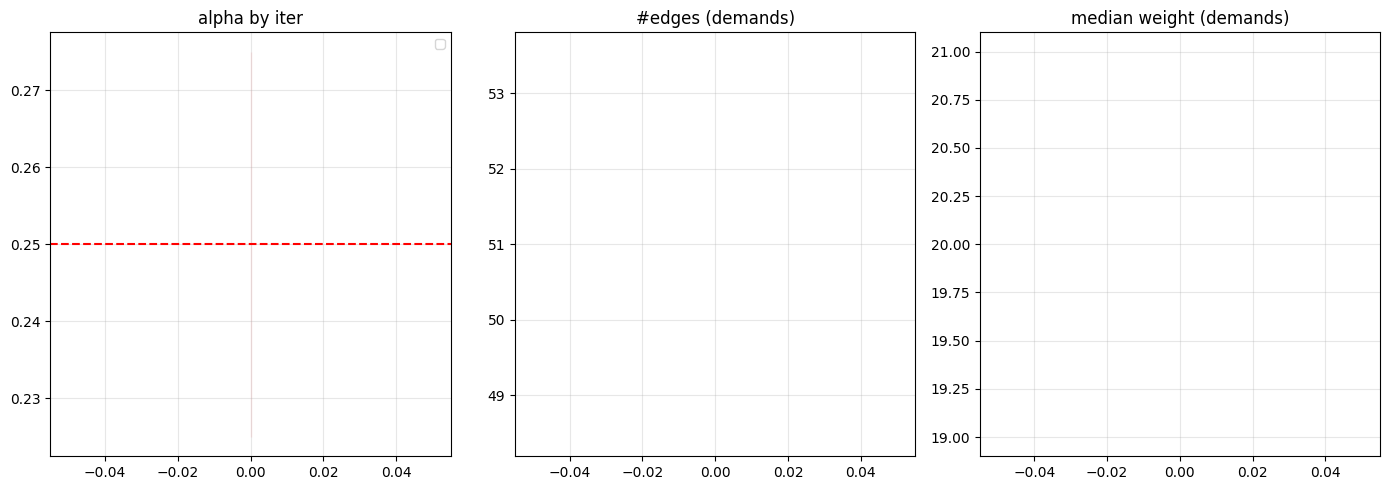

 метрика  initial  final
   edges       51     51
median_w       20     20
  mean_w       20     20
   sum_w     1035   1035


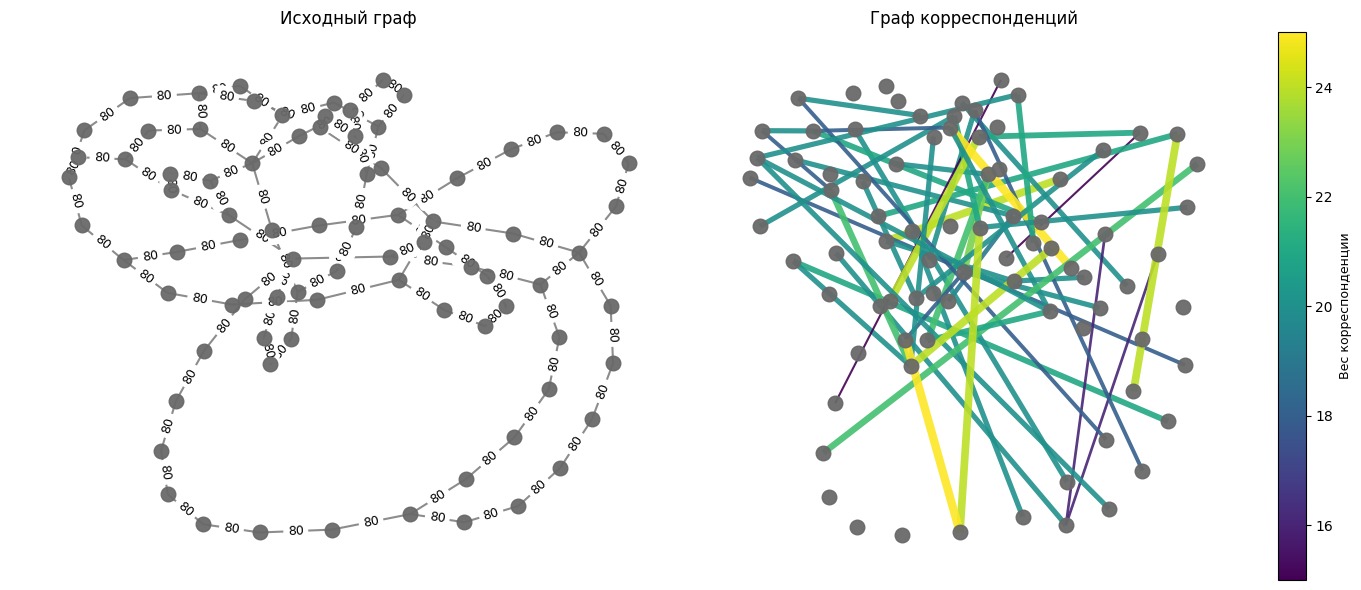

=== АНАЛИЗ (single run) ===
Время выполнения: 59.11 c
Итераций: 8300 (доля от максимума 8300 = 100.00%)
alpha_target=0.5, epsilon=0.025
initial_alpha=0.2737, final_alpha=0.3166, converged=False
Плохие шаги всего: 4114 (доля 0.50)
  — adversarial-плохих: 4114 (доля 0.50)
  — friendly-плохих:   0 (доля 0.00)


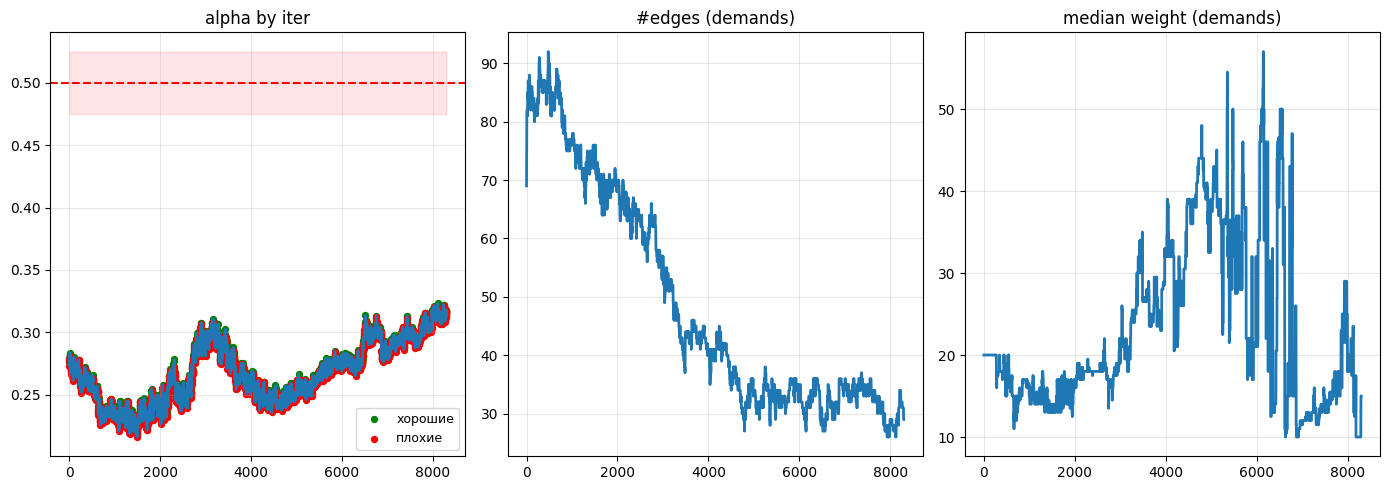

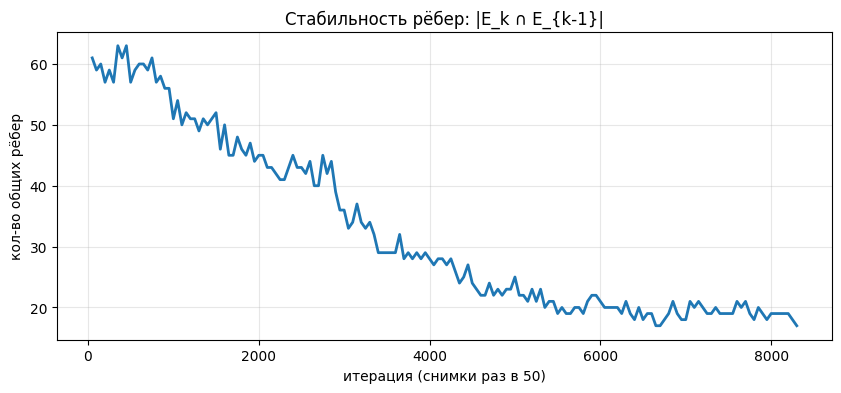

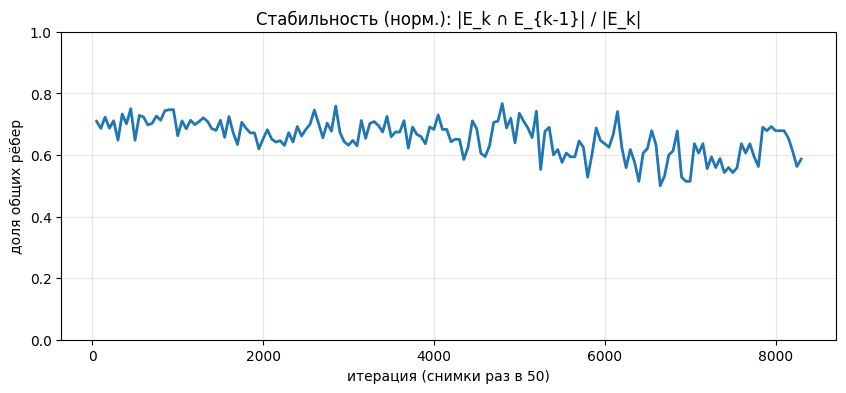

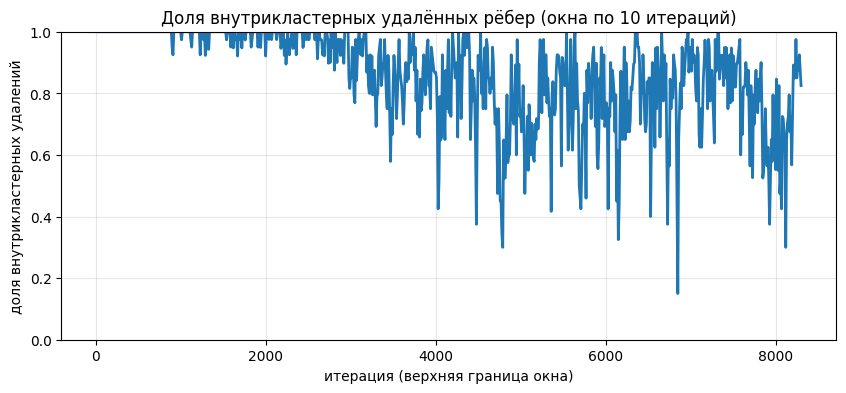

 метрика  initial  final
   edges       69     29
median_w       20     15
  mean_w       20     47
   sum_w     1365   1365


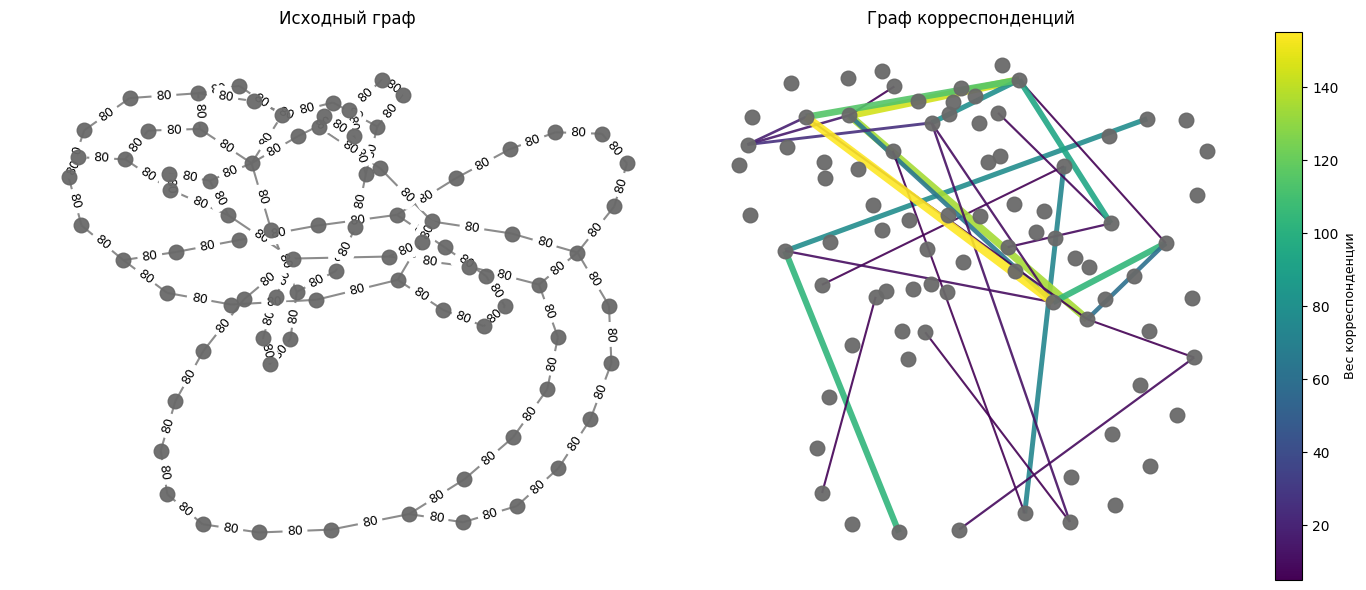

=== АНАЛИЗ (single run) ===
Время выполнения: 46.16 c
Итераций: 8300 (доля от максимума 8300 = 100.00%)
alpha_target=0.75, epsilon=0.025
initial_alpha=0.2555, final_alpha=0.3823, converged=False
Плохие шаги всего: 4157 (доля 0.50)
  — adversarial-плохих: 4157 (доля 0.50)
  — friendly-плохих:   0 (доля 0.00)


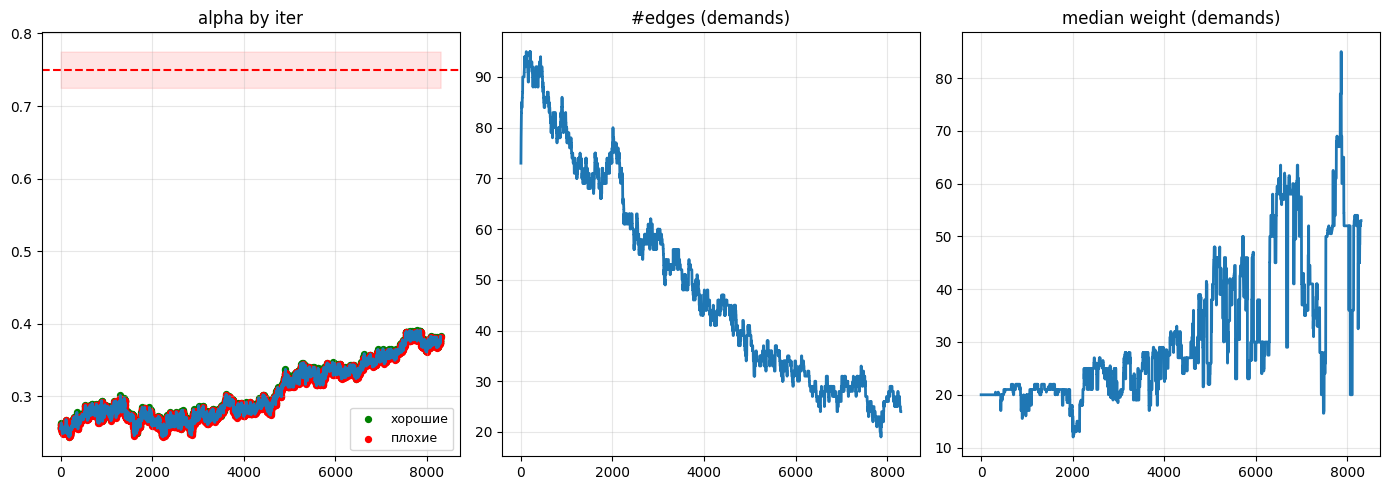

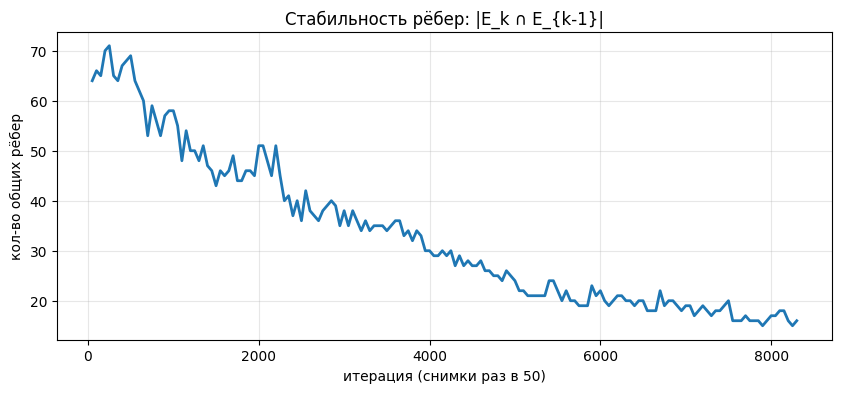

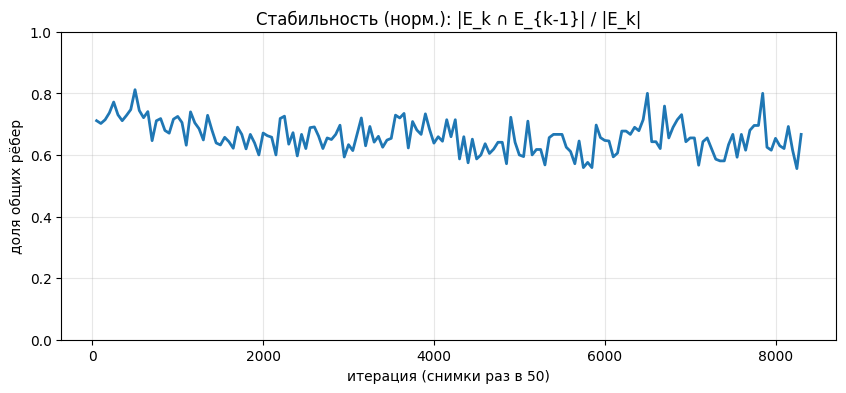

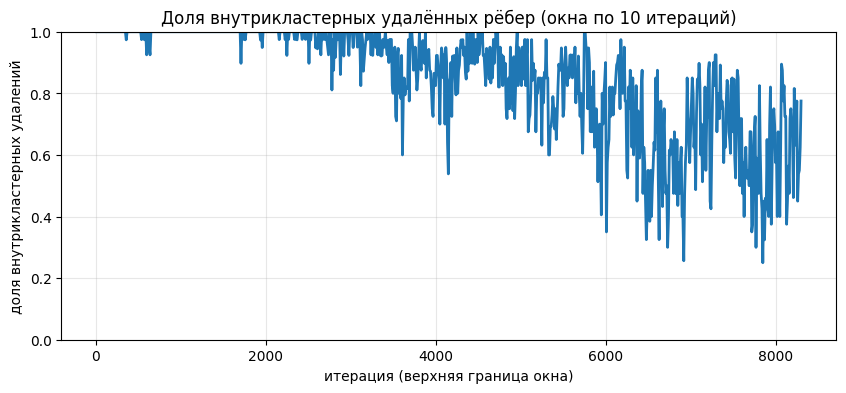

 метрика  initial  final
   edges       73     24
median_w       20     53
  mean_w       21     63
   sum_w     1507   1507


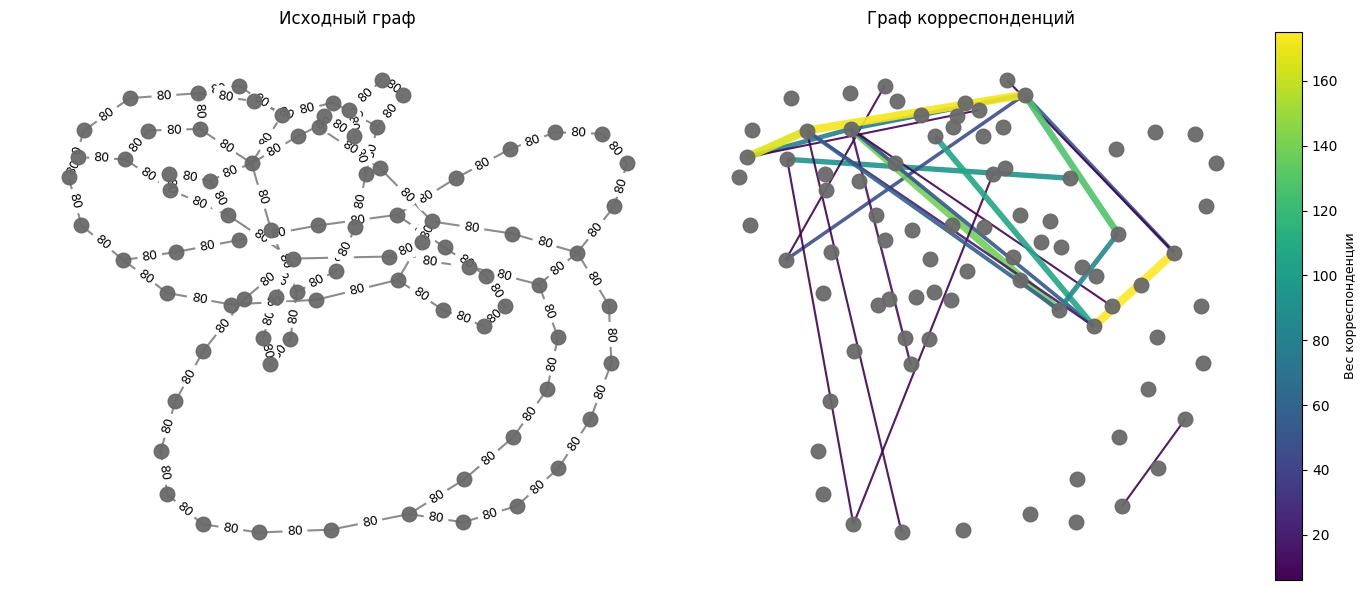



Решение MCF на итоге:
Значения gamma: alpha_target=0.25: 0.576 alpha_target=0.5: 0.291 alpha_target=0.75: 0.250
Средняя загруженность ребер: alpha_target=0.25: 0.132 alpha_target=0.5: 0.174 alpha_target=0.75: 0.192


=================================== Конец анализа работы алгоритма для cola_t10 ===================================


====================================   Анализ работы алгоритма для cola_t3  ====================================
=== АНАЛИЗ (single run) ===
Время выполнения: 0.35 c
Итераций: 88 (доля от максимума 2100 = 4.19%)
alpha_target=0.25, epsilon=0.025
initial_alpha=0.4781, final_alpha=0.2732, converged=True
Плохие шаги всего: 42 (доля 0.48)
  — adversarial-плохих: 0 (доля 0.00)
  — friendly-плохих:   42 (доля 0.48)


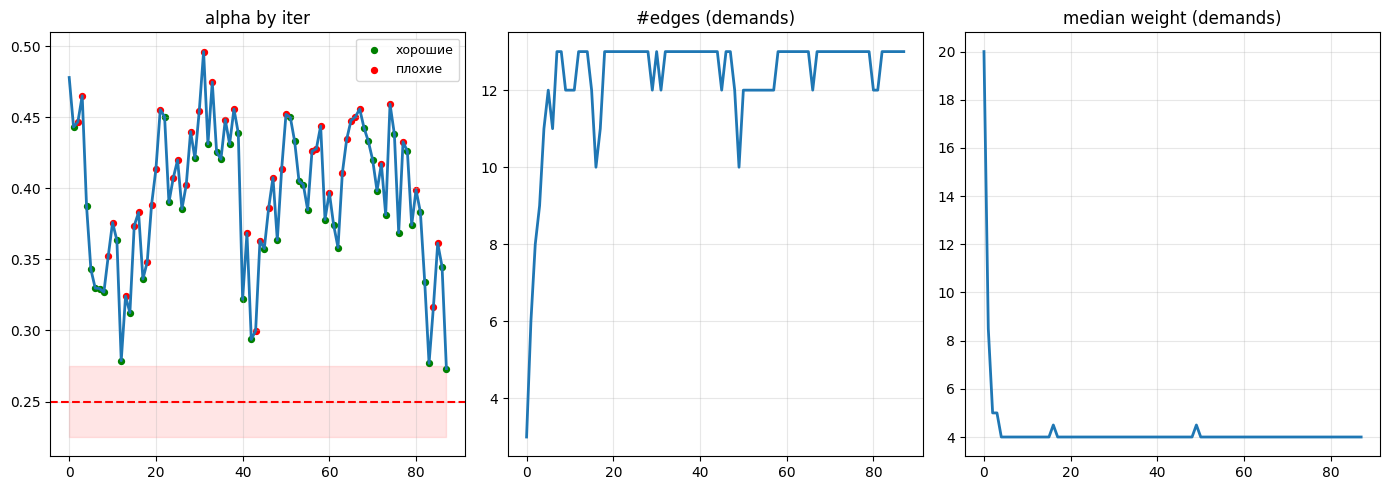

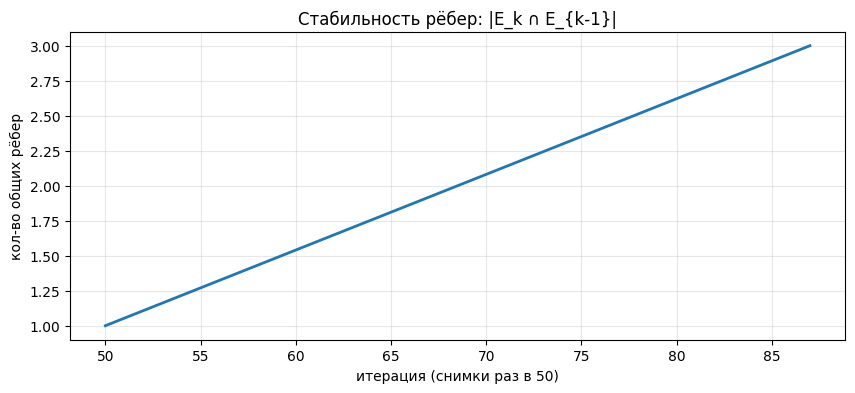

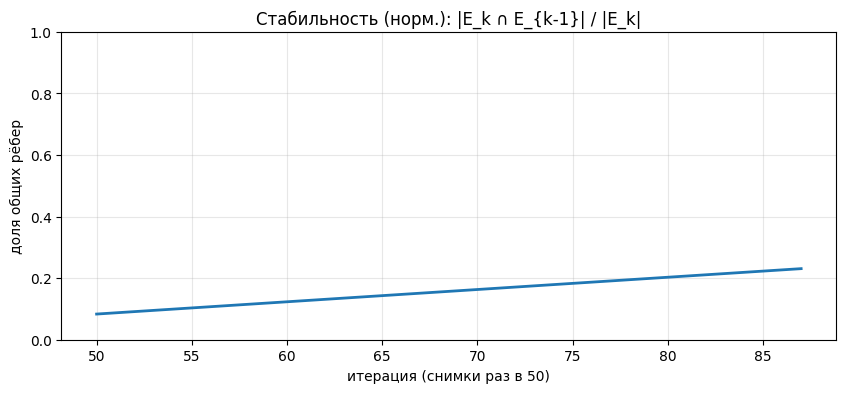

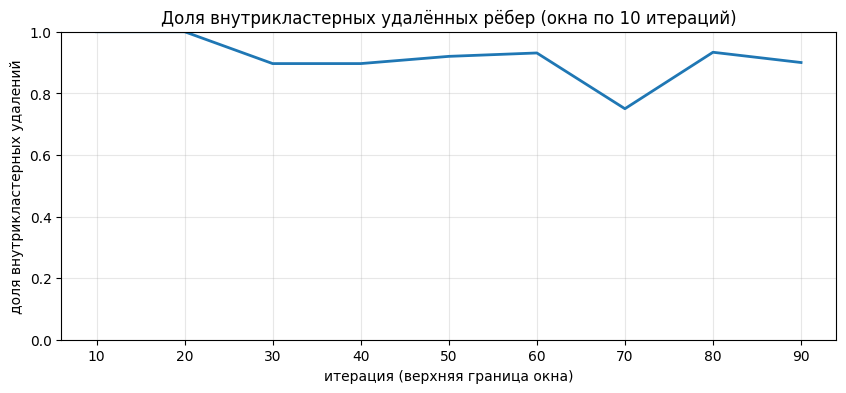

 метрика  initial  final
   edges        3     13
median_w       20      4
  mean_w       19      4
   sum_w       56     56


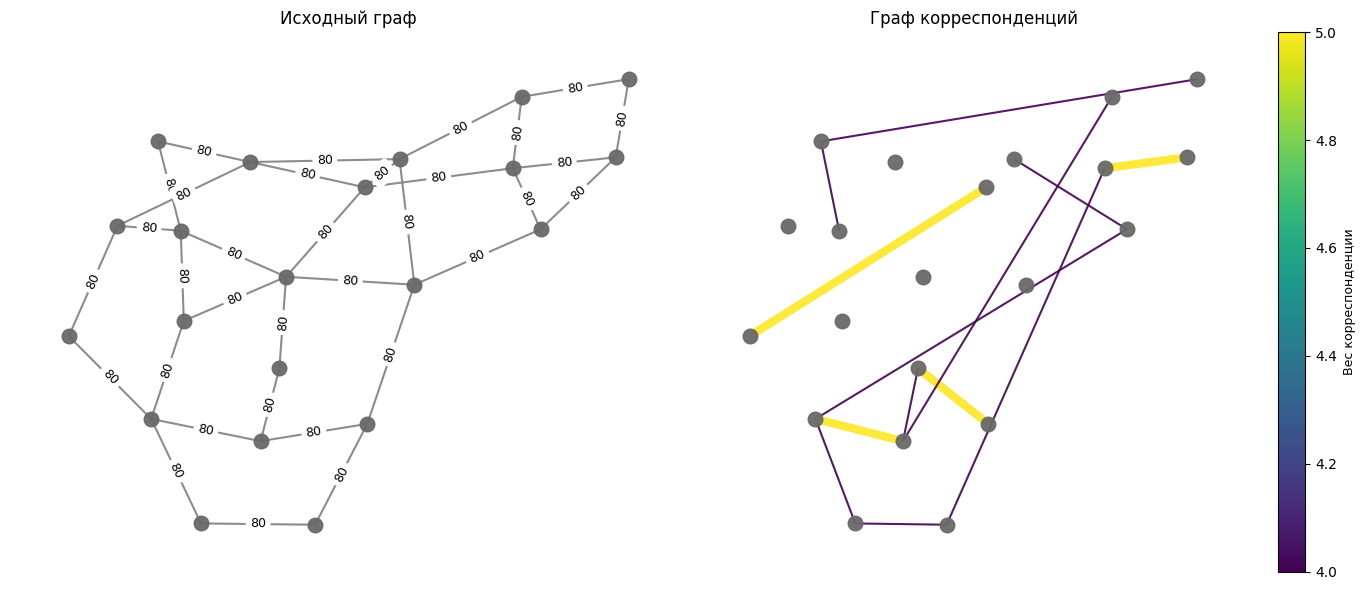

=== АНАЛИЗ (single run) ===
Время выполнения: 0.14 c
Итераций: 13 (доля от максимума 2100 = 0.62%)
alpha_target=0.5, epsilon=0.025
initial_alpha=0.4469, final_alpha=0.4866, converged=True
Плохие шаги всего: 5 (доля 0.42)
  — adversarial-плохих: 5 (доля 0.42)
  — friendly-плохих:   0 (доля 0.00)


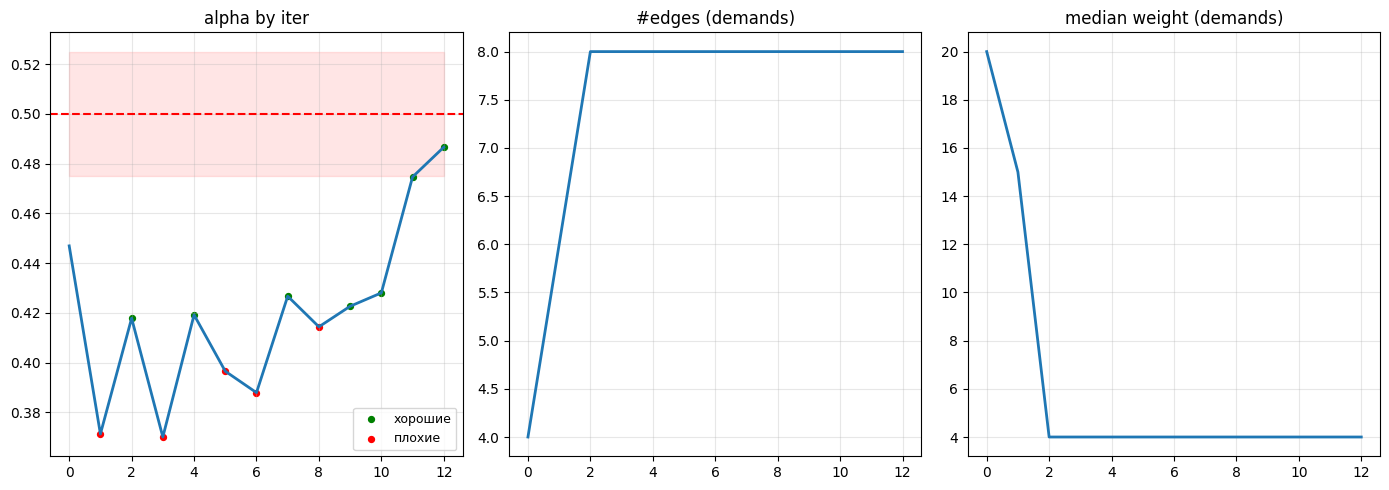

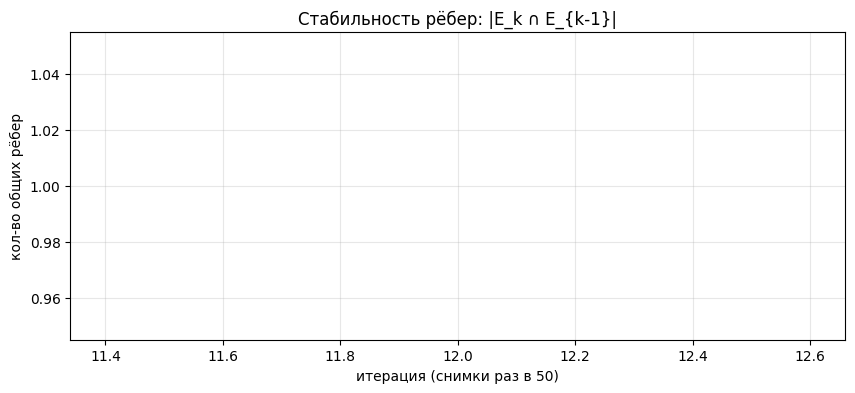

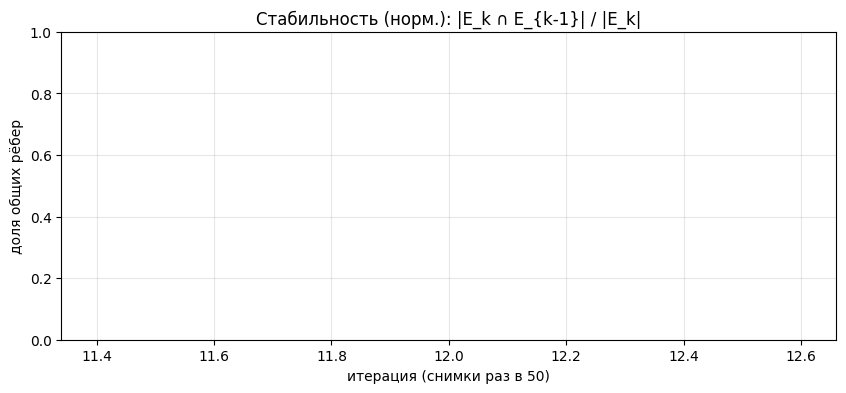

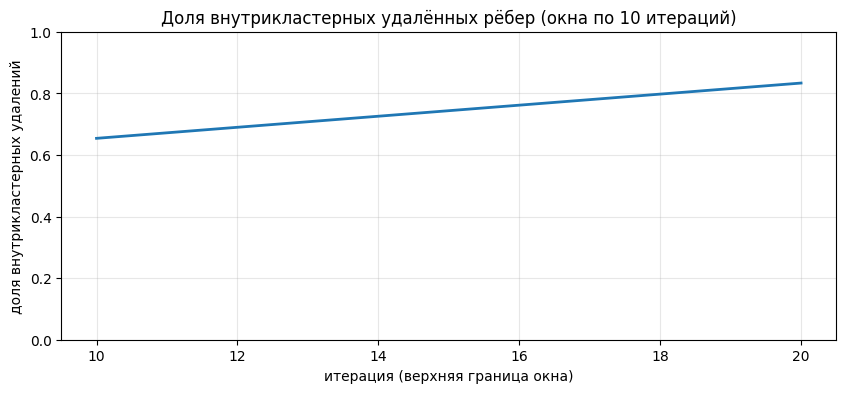

 метрика  initial  final
   edges        4      8
median_w       20      4
  mean_w       20     10
   sum_w       79     79


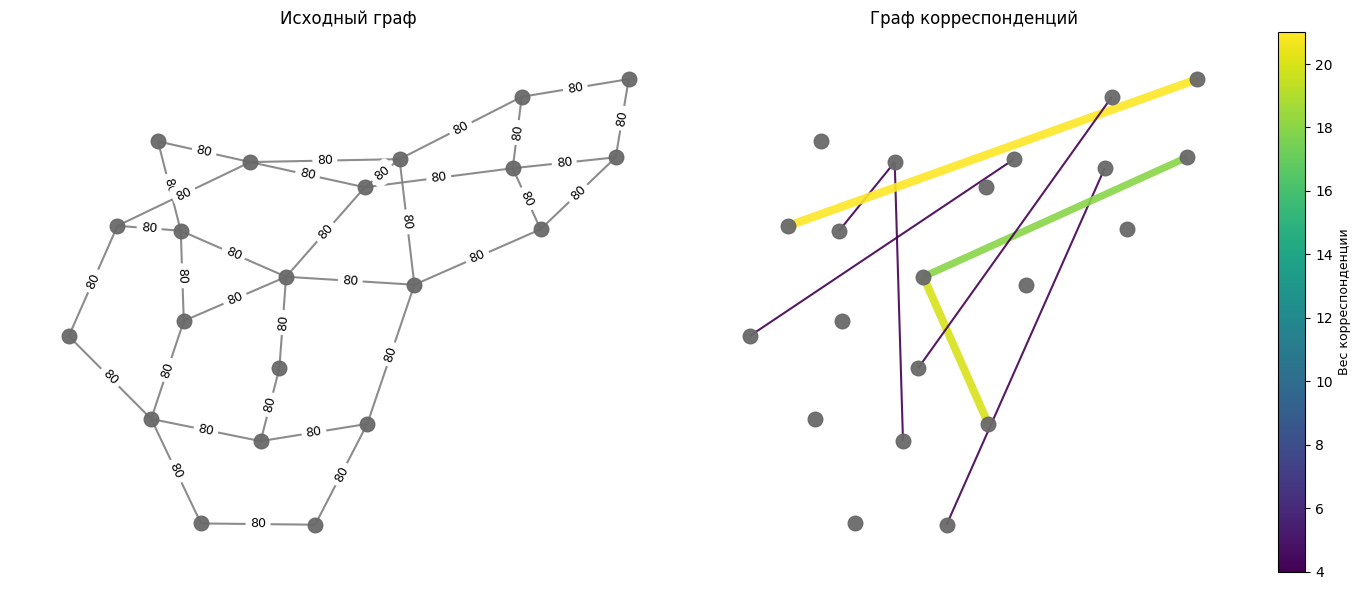

=== АНАЛИЗ (single run) ===
Время выполнения: 0.20 c
Итераций: 80 (доля от максимума 2100 = 3.81%)
alpha_target=0.75, epsilon=0.025
initial_alpha=0.3557, final_alpha=0.7350, converged=True
Плохие шаги всего: 38 (доля 0.48)
  — adversarial-плохих: 38 (доля 0.48)
  — friendly-плохих:   0 (доля 0.00)


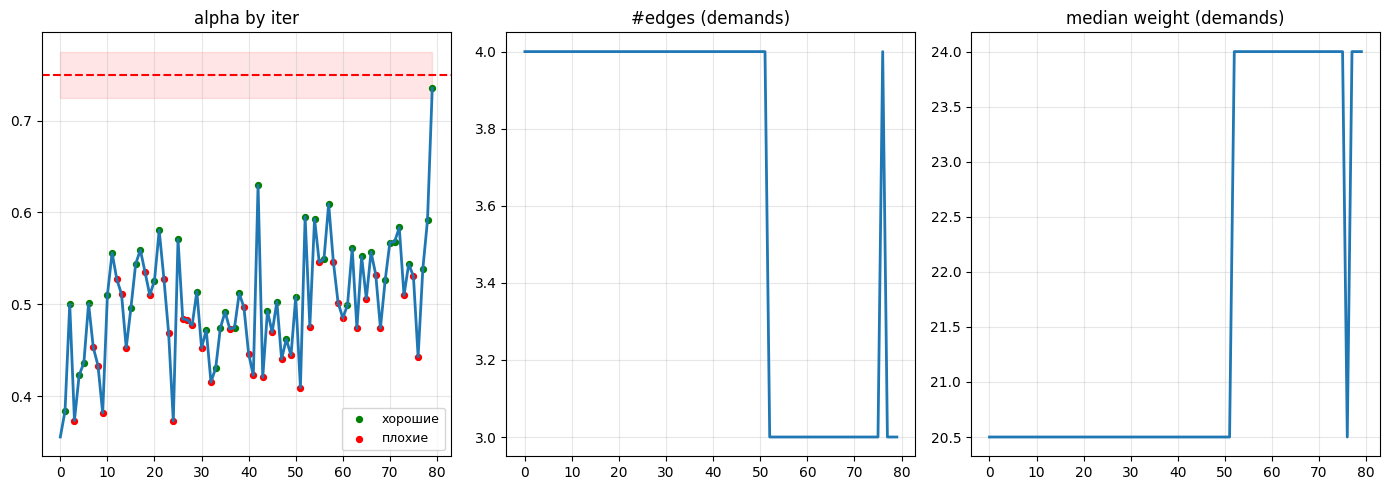

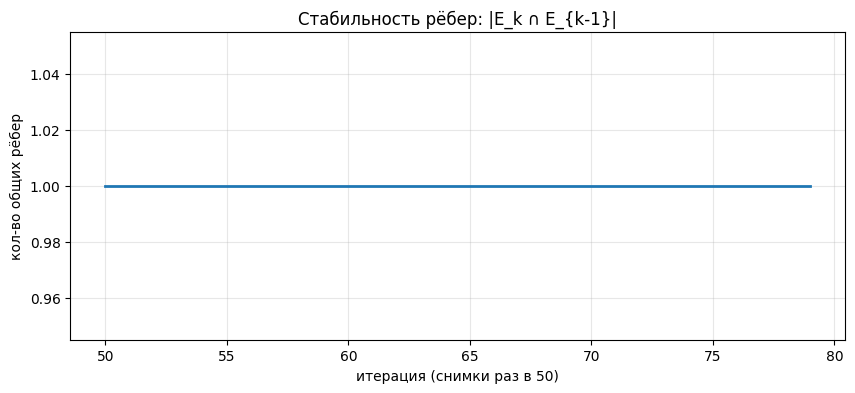

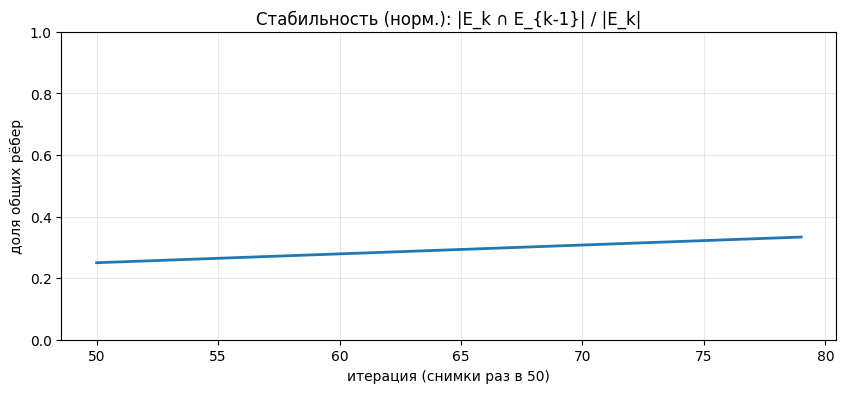

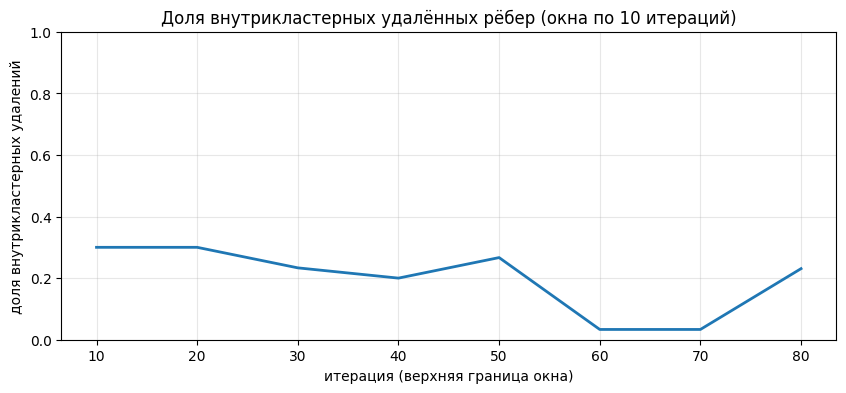

 метрика  initial  final
   edges        4      3
median_w       20     24
  mean_w       20     27
   sum_w       82     82


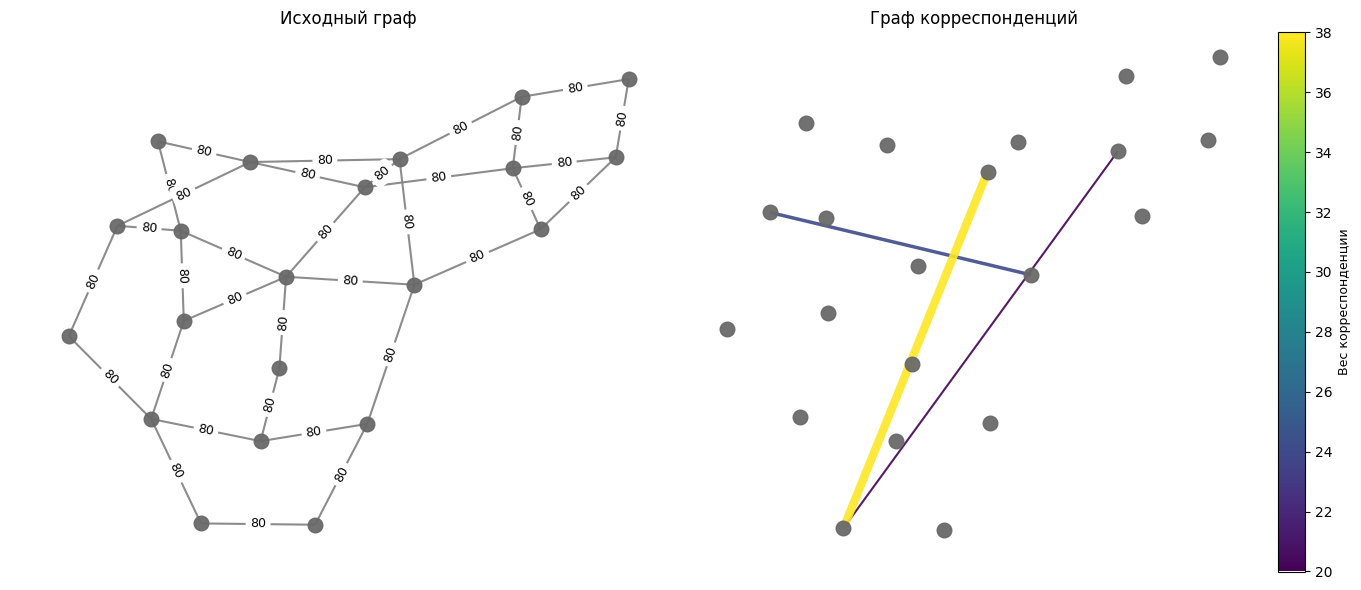



Решение MCF на итоге:
Значения gamma: alpha_target=0.25: 12.000 alpha_target=0.5: 5.106 alpha_target=0.75: 2.759
Средняя загруженность ребер: alpha_target=0.25: 0.021 alpha_target=0.5: 0.030 alpha_target=0.75: 0.031


=================================== Конец анализа работы алгоритма для cola_t3 ===================================


====================================   Анализ работы алгоритма для cola_t8  ====================================
=== АНАЛИЗ (single run) ===
Время выполнения: 0.37 c
Итераций: 68 (доля от максимума 5400 = 1.26%)
alpha_target=0.25, epsilon=0.025
initial_alpha=0.3738, final_alpha=0.2684, converged=True
Плохие шаги всего: 28 (доля 0.42)
  — adversarial-плохих: 0 (доля 0.00)
  — friendly-плохих:   28 (доля 0.42)


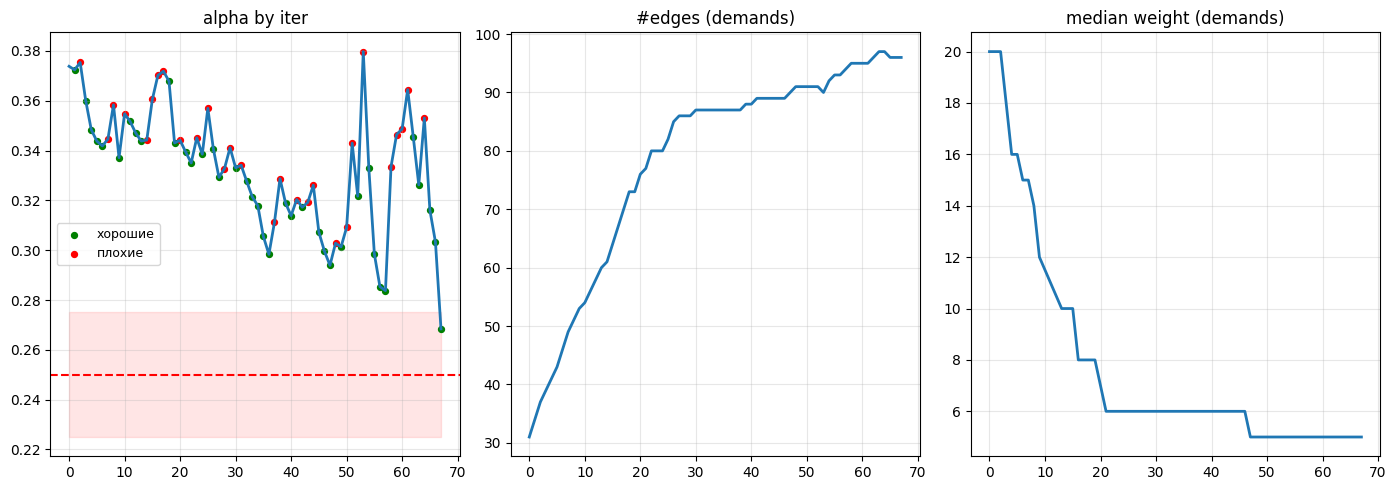

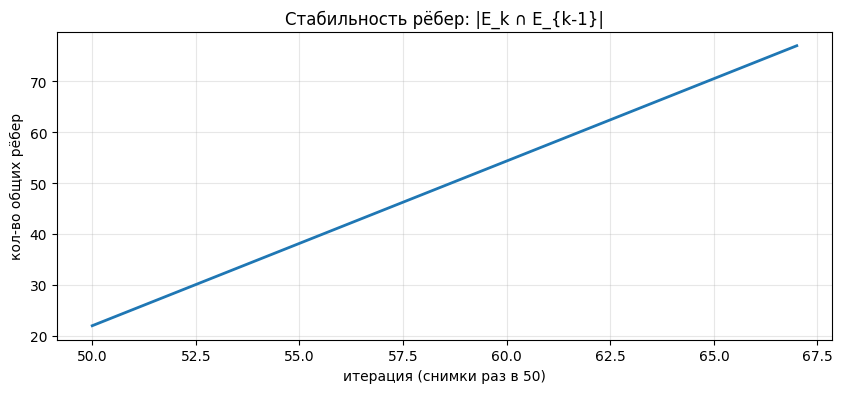

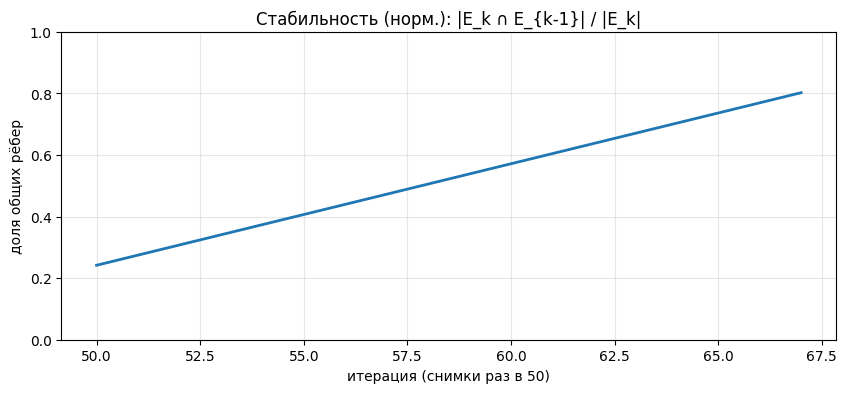

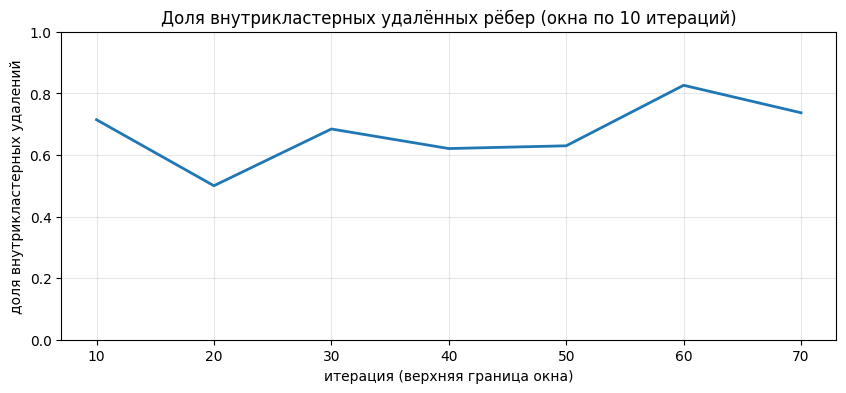

 метрика  initial  final
   edges       31     96
median_w       20      5
  mean_w       20      7
   sum_w      625    625


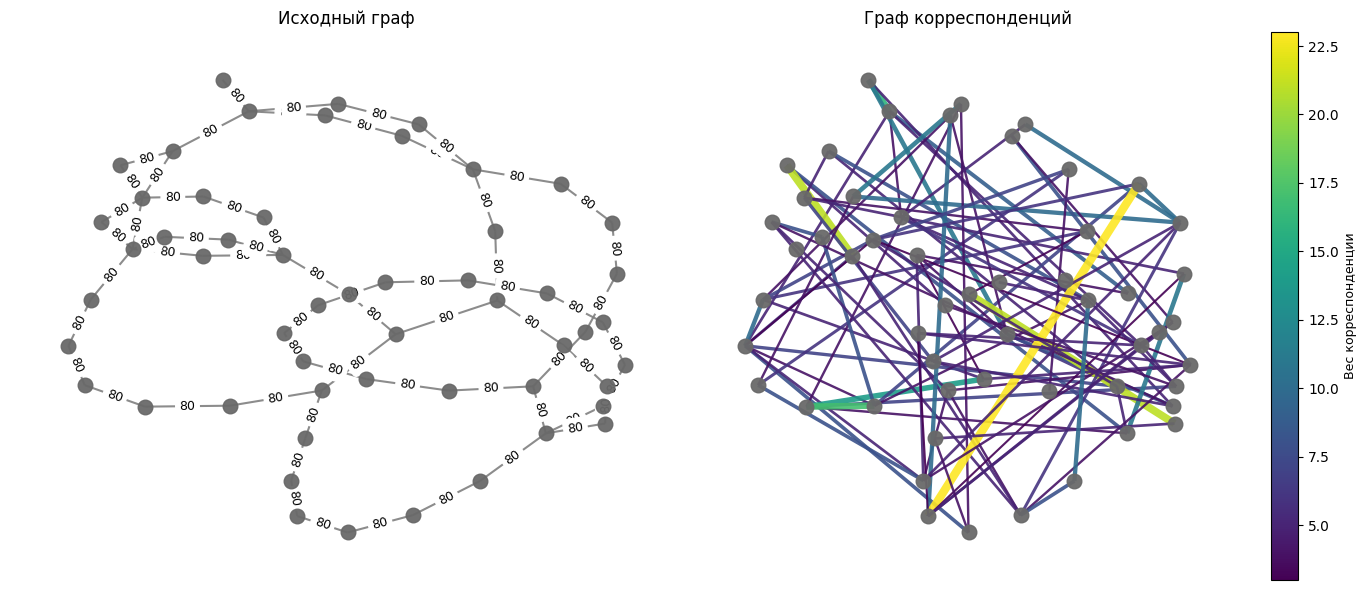

=== АНАЛИЗ (single run) ===
Время выполнения: 14.32 c
Итераций: 3233 (доля от максимума 5400 = 59.87%)
alpha_target=0.5, epsilon=0.025
initial_alpha=0.3718, final_alpha=0.4751, converged=True
Плохие шаги всего: 1612 (доля 0.50)
  — adversarial-плохих: 1612 (доля 0.50)
  — friendly-плохих:   0 (доля 0.00)


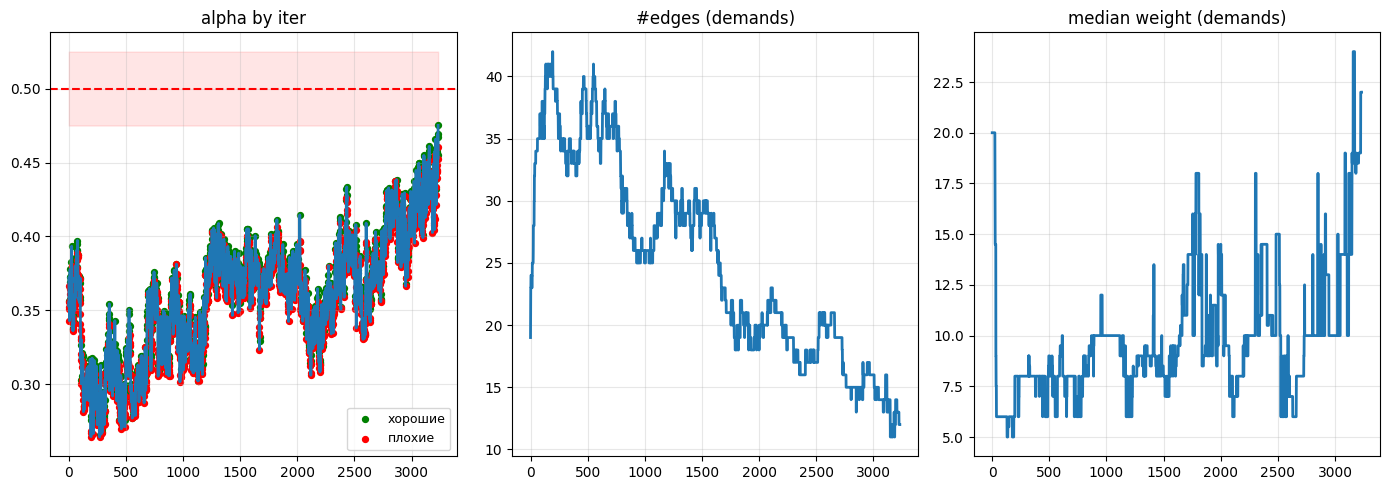

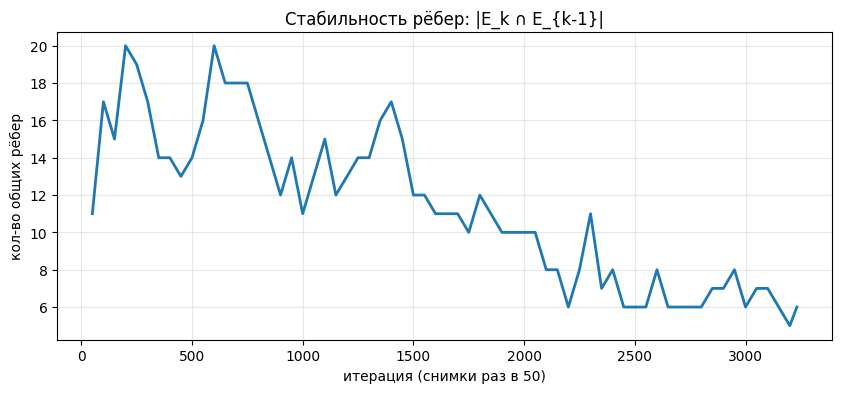

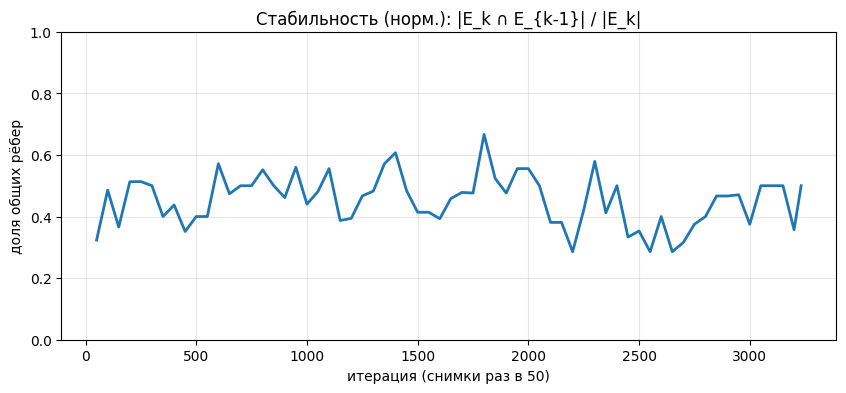

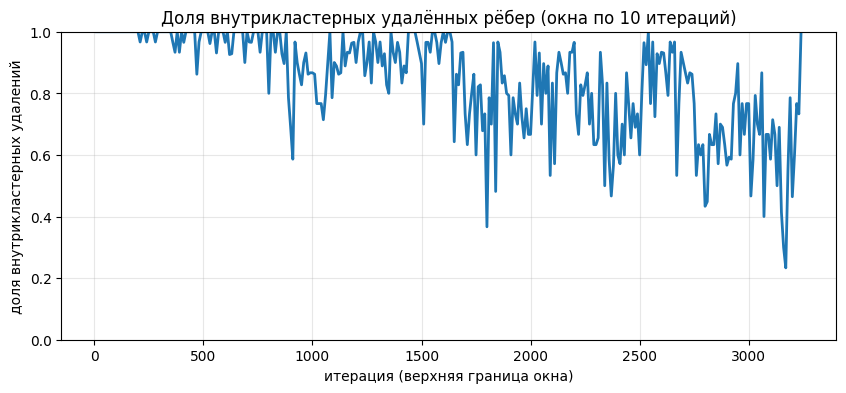

 метрика  initial  final
   edges       19     12
median_w       20     22
  mean_w       20     32
   sum_w      378    378


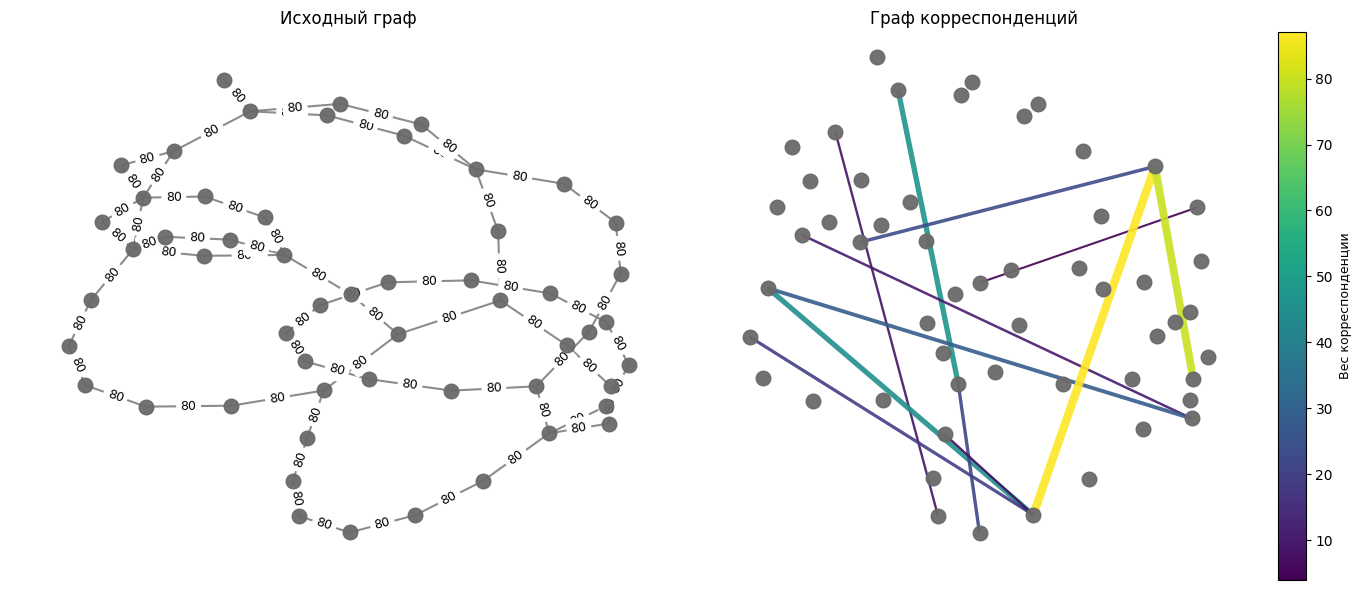

=== АНАЛИЗ (single run) ===
Время выполнения: 23.49 c
Итераций: 5400 (доля от максимума 5400 = 100.00%)
alpha_target=0.75, epsilon=0.025
initial_alpha=0.3892, final_alpha=0.4702, converged=False
Плохие шаги всего: 2637 (доля 0.49)
  — adversarial-плохих: 2637 (доля 0.49)
  — friendly-плохих:   0 (доля 0.00)


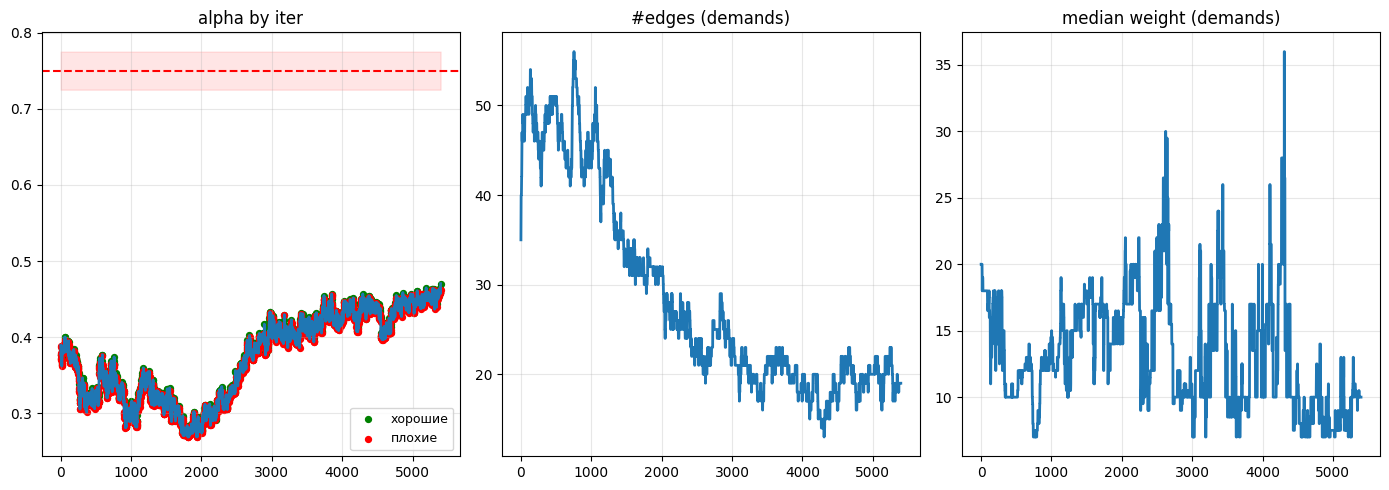

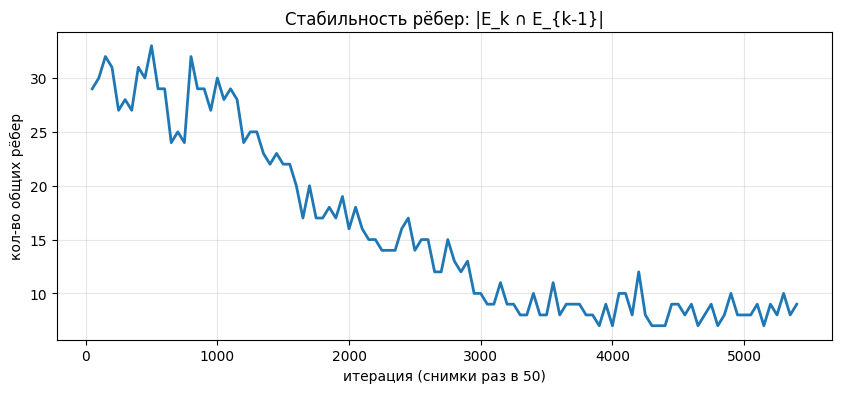

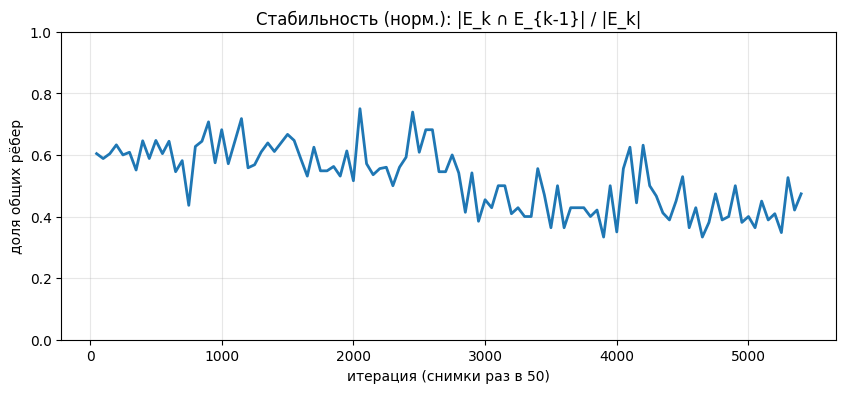

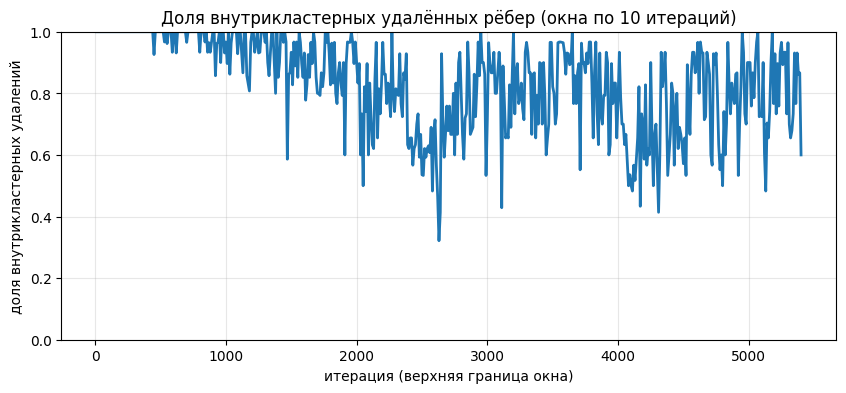

 метрика  initial  final
   edges       35     19
median_w       20     10
  mean_w       20     36
   sum_w      685    685


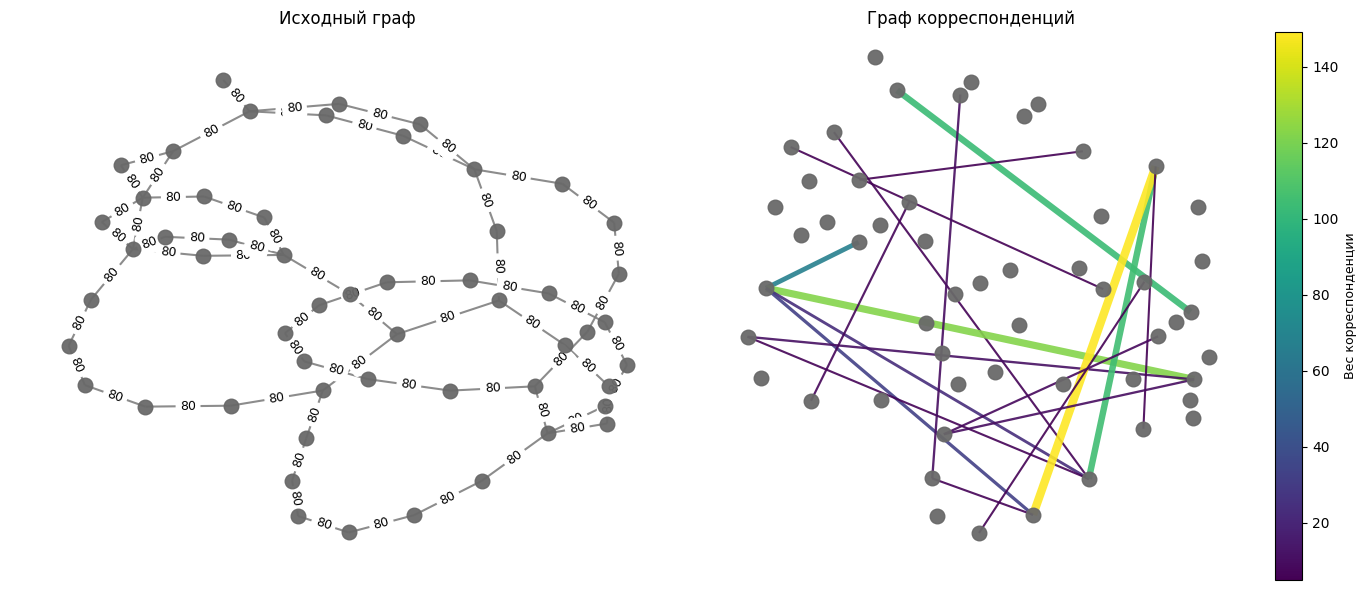



Решение MCF на итоге:
Значения gamma: alpha_target=0.25: 0.719 alpha_target=0.5: 0.779 alpha_target=0.75: 0.406
Средняя загруженность ребер: alpha_target=0.25: 0.124 alpha_target=0.5: 0.075 alpha_target=0.75: 0.136


=================================== Конец анализа работы алгоритма для cola_t8 ===================================


====================================   Анализ работы алгоритма для cola_t2  ====================================
=== АНАЛИЗ (single run) ===
Время выполнения: 0.02 c
Итераций: 7 (доля от максимума 3200 = 0.22%)
alpha_target=0.25, epsilon=0.025
initial_alpha=0.2966, final_alpha=0.2739, converged=True
Плохие шаги всего: 3 (доля 0.50)
  — adversarial-плохих: 0 (доля 0.00)
  — friendly-плохих:   3 (доля 0.50)


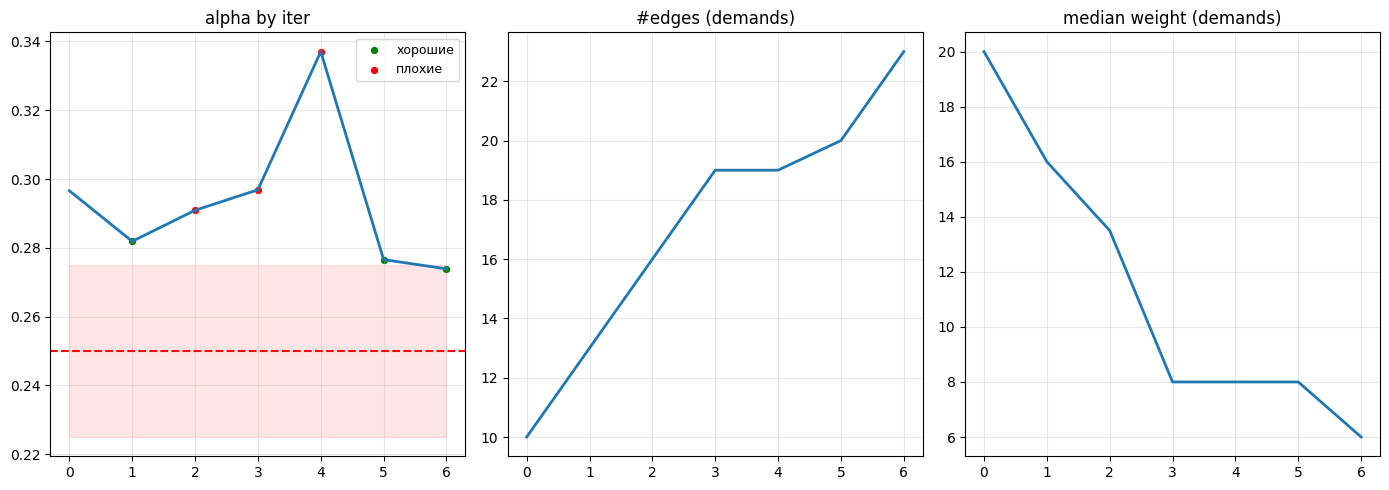

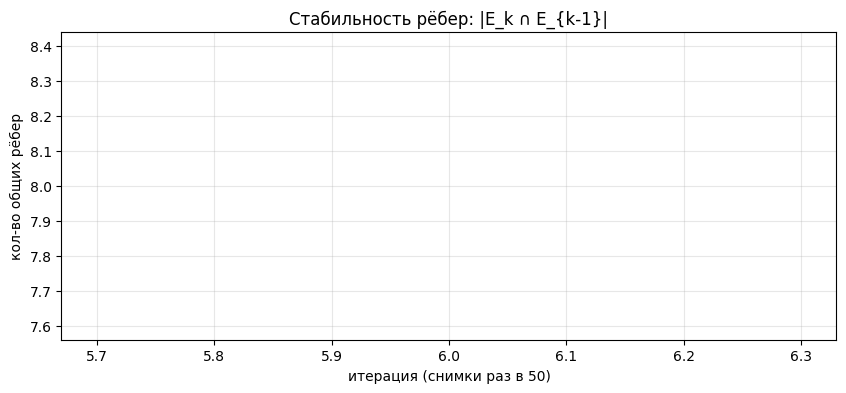

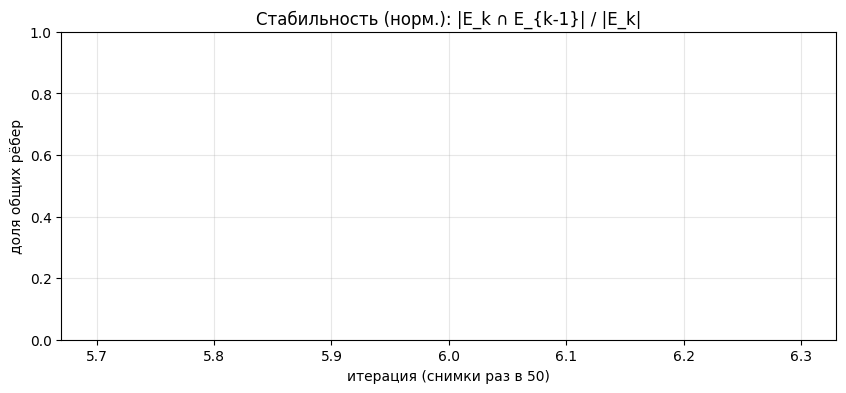

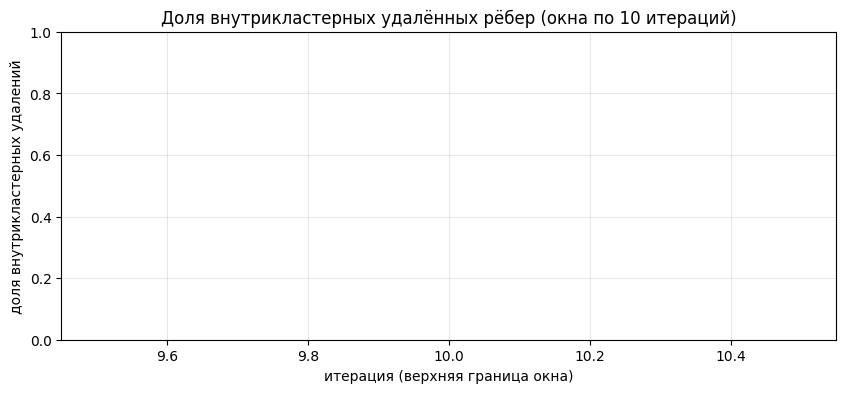

 метрика  initial  final
   edges       10     23
median_w       20      6
  mean_w       20      8
   sum_w      195    195


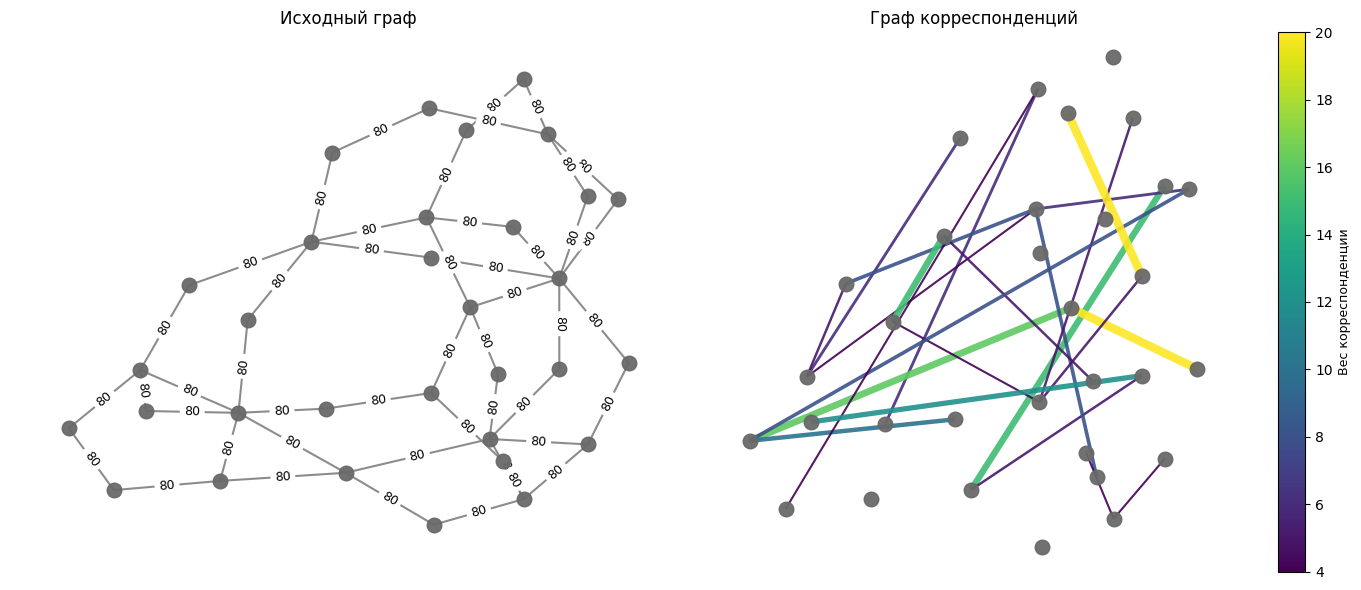

=== АНАЛИЗ (single run) ===
Время выполнения: 0.50 c
Итераций: 329 (доля от максимума 3200 = 10.28%)
alpha_target=0.5, epsilon=0.025
initial_alpha=0.3014, final_alpha=0.4892, converged=True
Плохие шаги всего: 159 (доля 0.48)
  — adversarial-плохих: 159 (доля 0.48)
  — friendly-плохих:   0 (доля 0.00)


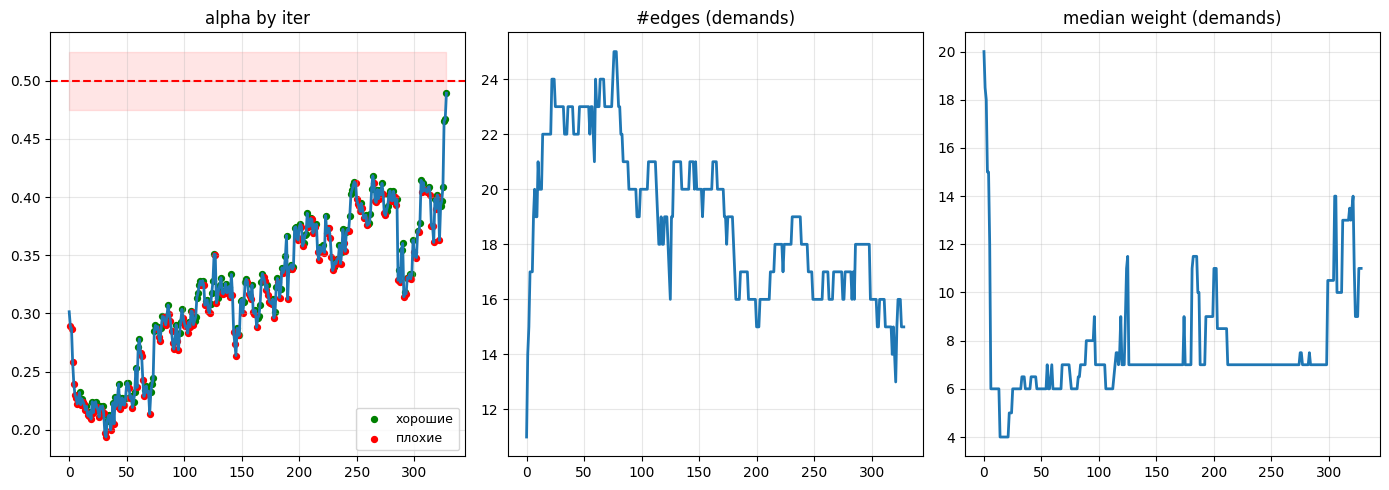

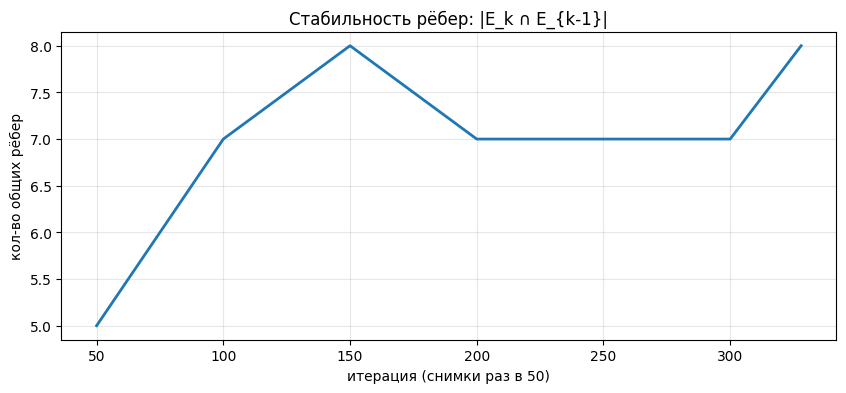

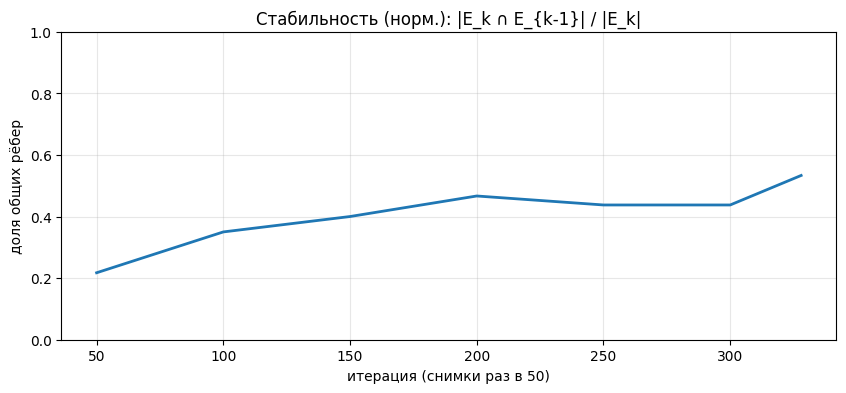

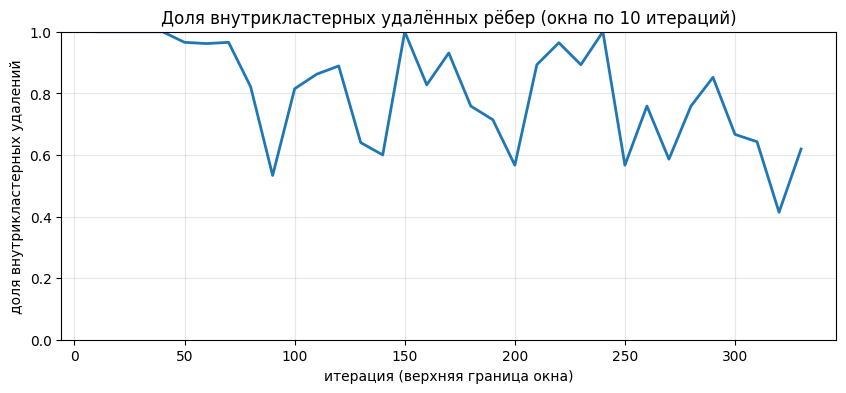

 метрика  initial  final
   edges       11     15
median_w       20     11
  mean_w       20     14
   sum_w      215    215


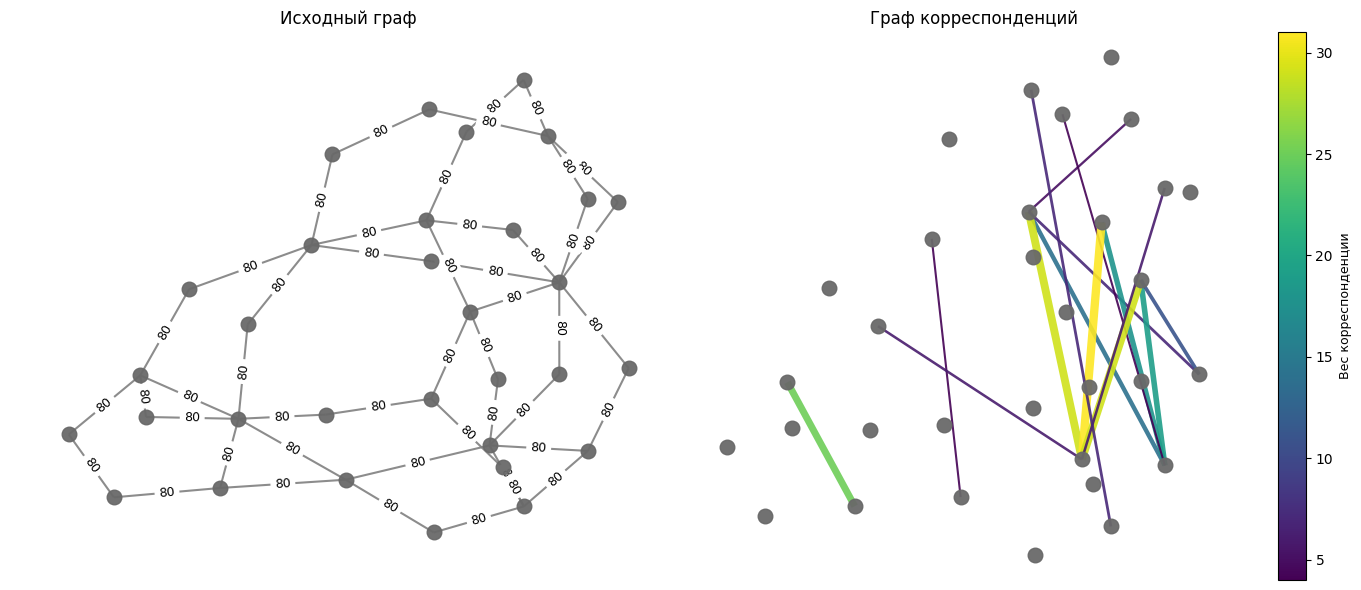

=== АНАЛИЗ (single run) ===
Время выполнения: 1.91 c
Итераций: 1383 (доля от максимума 3200 = 43.22%)
alpha_target=0.75, epsilon=0.025
initial_alpha=0.2807, final_alpha=0.7345, converged=True
Плохие шаги всего: 650 (доля 0.47)
  — adversarial-плохих: 650 (доля 0.47)
  — friendly-плохих:   0 (доля 0.00)


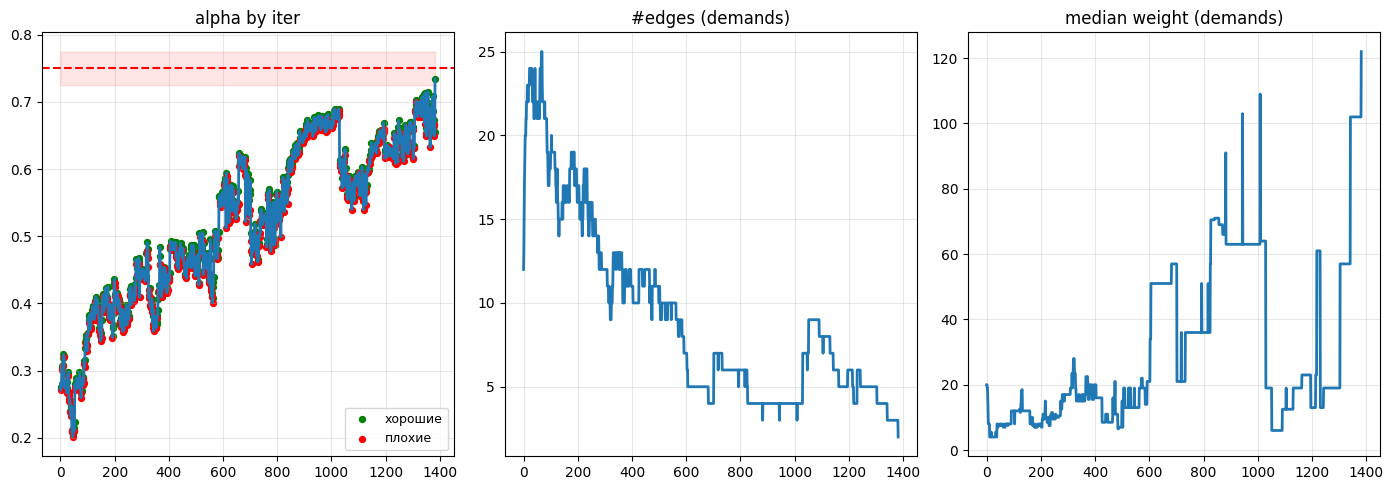

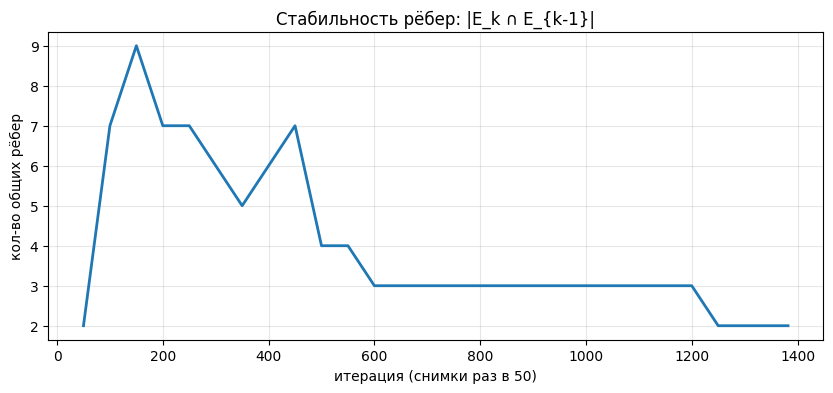

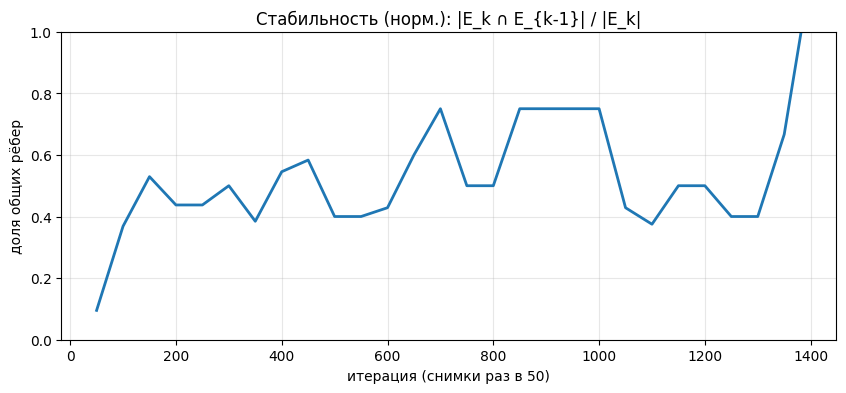

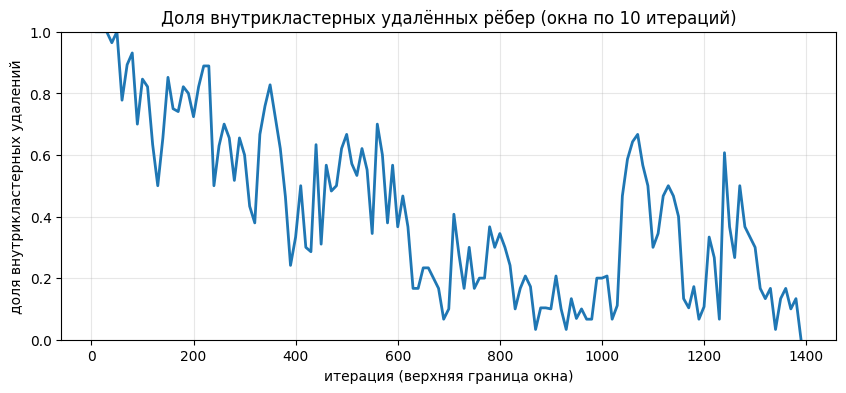

 метрика  initial  final
   edges       12      2
median_w       20    122
  mean_w       20    122
   sum_w      244    244


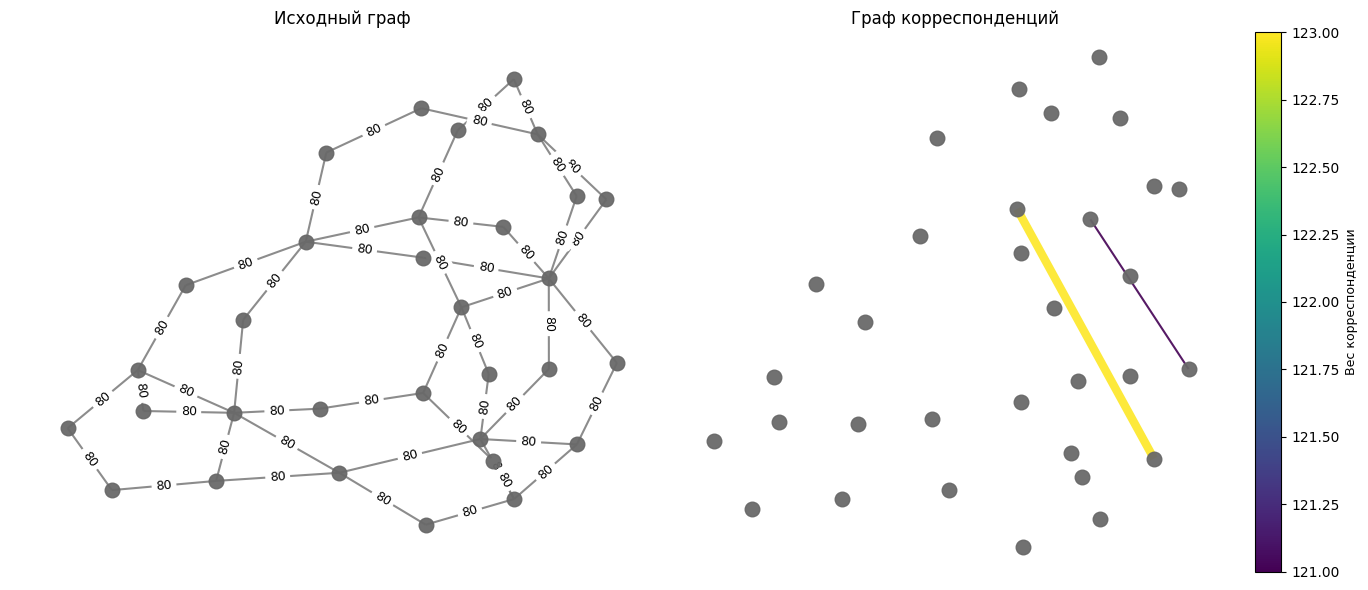



Решение MCF на итоге:
Значения gamma: alpha_target=0.25: 3.380 alpha_target=0.5: 2.595 alpha_target=0.75: 0.984
Средняя загруженность ребер: alpha_target=0.25: 0.052 alpha_target=0.5: 0.057 alpha_target=0.75: 0.065


=================================== Конец анализа работы алгоритма для cola_t2 ===================================




In [8]:
import numpy as np
from graphmcf import GraphMCF
from graphmcf.demands import MCFGeneratorMultiGraph
from graphmcf.analysis import analyze_simple

alphas_batch = [0.25, 0.5, 0.75] # должна быть хорошая, средняя, плохая проходимость, gamma убывает

for name, graph in small_graphs_for_test.items():
  alphas_gamma = []
  alphas_workload = [] # считаем среднюю нагруженность ребер как sum(веса ребер self.demands_graph) / sum(веса ребер self.graph), так как capacity одинаковая на графах
  print(f"====================================   Анализ работы алгоритма для {name}  ====================================")

  for alpha_target in alphas_batch:
    graph_for_mcf = GraphMCF(graph['adj_matrix'])
    gen = MCFGeneratorMultiGraph(epsilon=0.025,
                                 p_ER = 0.02, distribution="normal", median_weight_for_initial=20, var_for_initial=5, multi_max=5,
                                 num_edges=None,)
    res = gen.generate(graph=graph_for_mcf, alpha_target=alpha_target)
    analyze_simple(graph_for_mcf, alpha_target=alpha_target, epsilon=0.025,
                   start_time=res.start_time, end_time=res.end_time,
                   alpha_history=res.alpha_history,
                   edge_counts_history=res.edge_counts_history,
                   median_weights_history=res.median_weights_history,
                   edge_mask_history=res.edge_mask_history,
                   edge_mask_snapshot_iters=res.edge_mask_snapshot_iters,
                   removal_events=res.removal_events,
                   algo_params=res.algo_params)
    graph_for_mcf.visualise_with_demands()

    sol = solve_throughput(graph_for_mcf.graph, graph_for_mcf.demands_laplacian)
    gamma = sol.gamma
    alphas_gamma.append(f"alpha_target={alpha_target}: {gamma:.3f}")

    demands_sum = sum(data['weight'] for u, v, data in graph_for_mcf.demands_graph.edges(data=True))
    capacity_sum = sum(data['weight'] for u, v, data in graph_for_mcf.graph.edges(data=True))
    workload = demands_sum / capacity_sum
    alphas_workload.append(f"alpha_target={alpha_target}: {workload:.3f}")

  gamma_sequence = " ".join(alphas_gamma)
  workload_sequence = " ".join(alphas_workload)
  print(f"\n\nРешение MCF на итоге:\nЗначения gamma: {gamma_sequence}\nСредняя загруженность ребер: {workload_sequence}\n\n")
  print(f"=================================== Конец анализа работы алгоритма для {name} ===================================\n\n")

In [9]:
med_graph_for_test_name = 'cola_t7'
med_graph_for_test = get_graphs(path_to_folder, med_graph_for_test_name, True)[med_graph_for_test_name]

=== АНАЛИЗ (single run) ===
Время выполнения: 0.94 c
Итераций: 81 (доля от максимума 16200 = 0.50%)
alpha_target=0.15, epsilon=0.025
initial_alpha=0.2108, final_alpha=0.1742, converged=True
Плохие шаги всего: 35 (доля 0.44)
  — adversarial-плохих: 0 (доля 0.00)
  — friendly-плохих:   35 (доля 0.44)


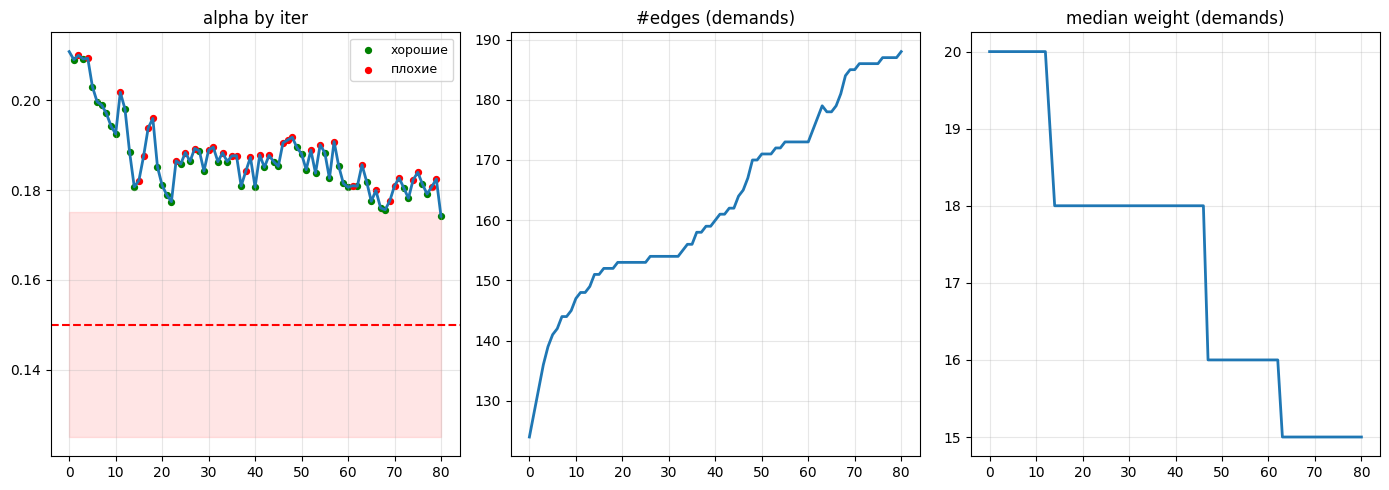

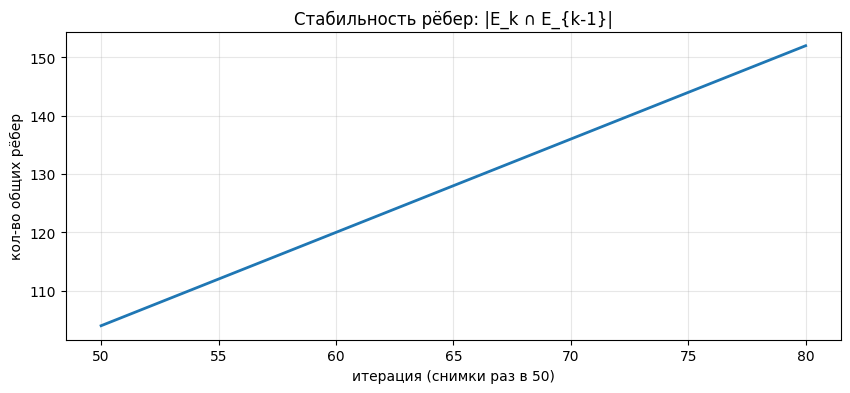

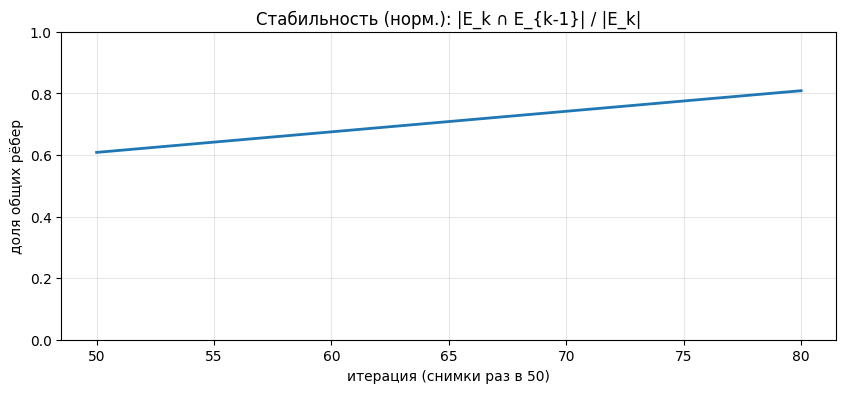

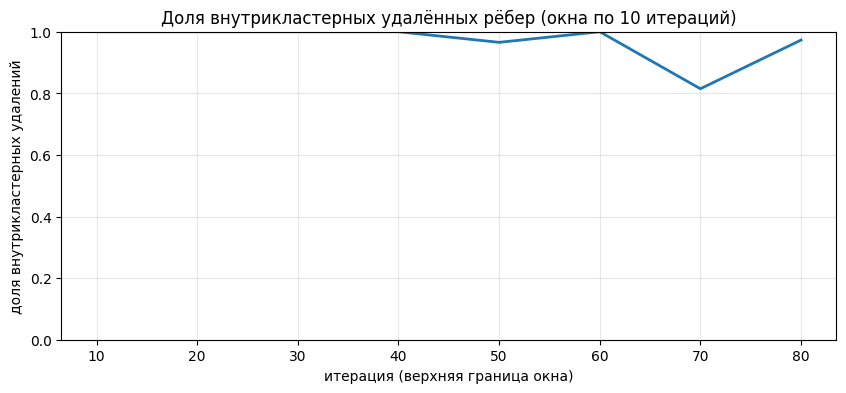

 метрика  initial  final
   edges      124    188
median_w       20     15
  mean_w       20     13
   sum_w     2528   2528


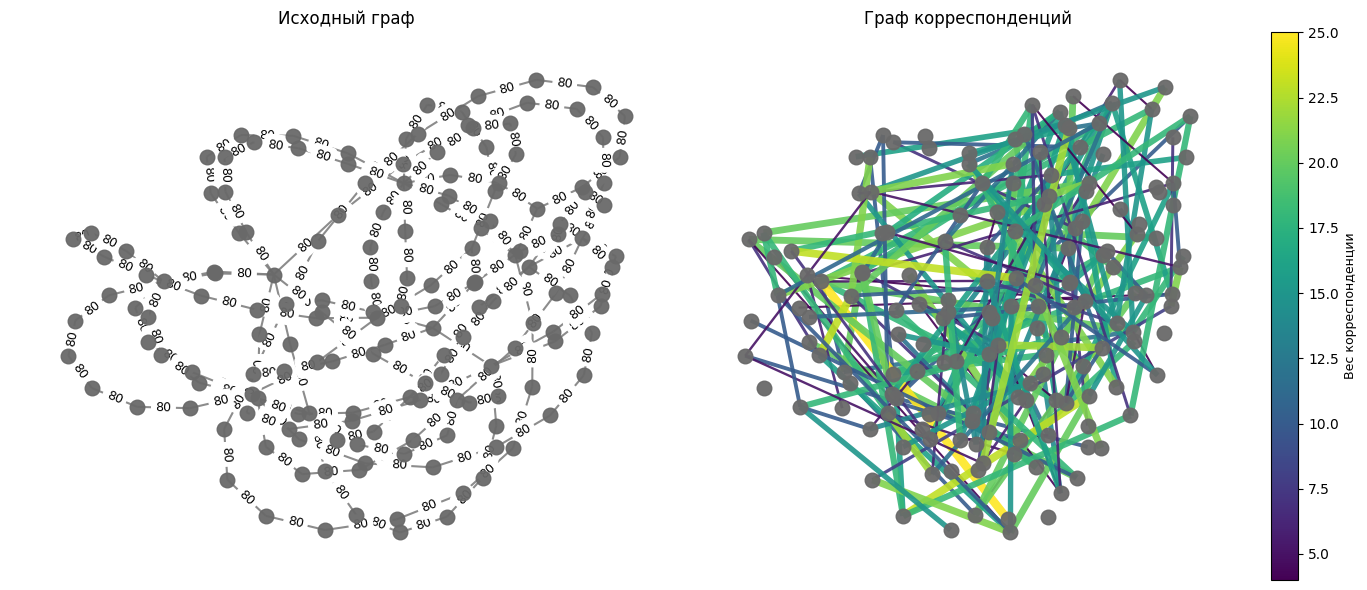

=== АНАЛИЗ (single run) ===
Время выполнения: 168.47 c
Итераций: 16200 (доля от максимума 16200 = 100.00%)
alpha_target=0.35, epsilon=0.025
initial_alpha=0.1750, final_alpha=0.2230, converged=False
Плохие шаги всего: 8049 (доля 0.50)
  — adversarial-плохих: 8049 (доля 0.50)
  — friendly-плохих:   0 (доля 0.00)


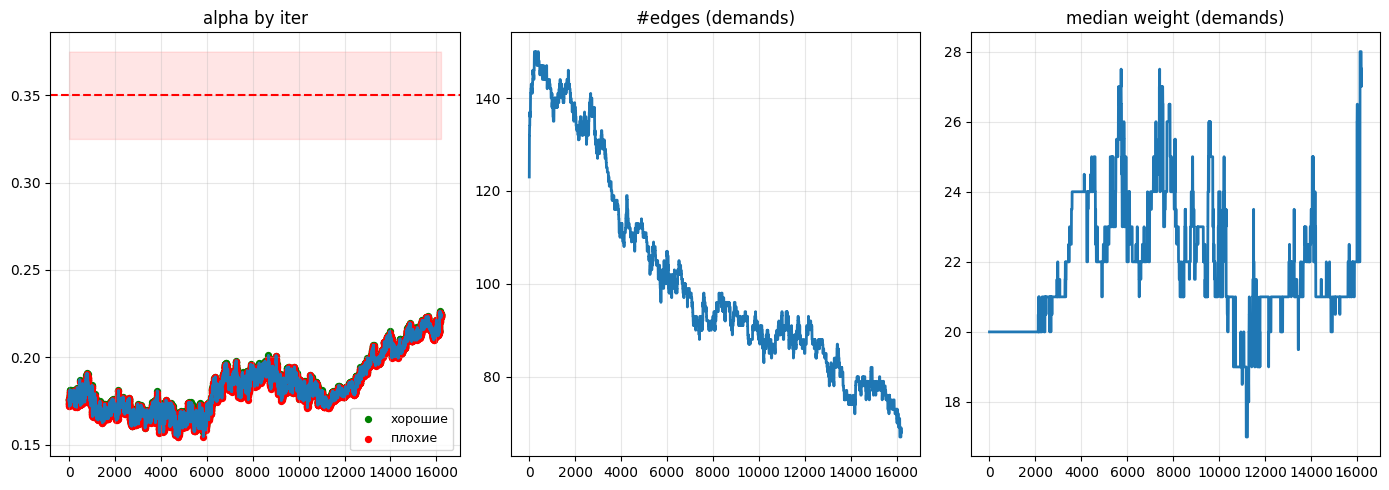

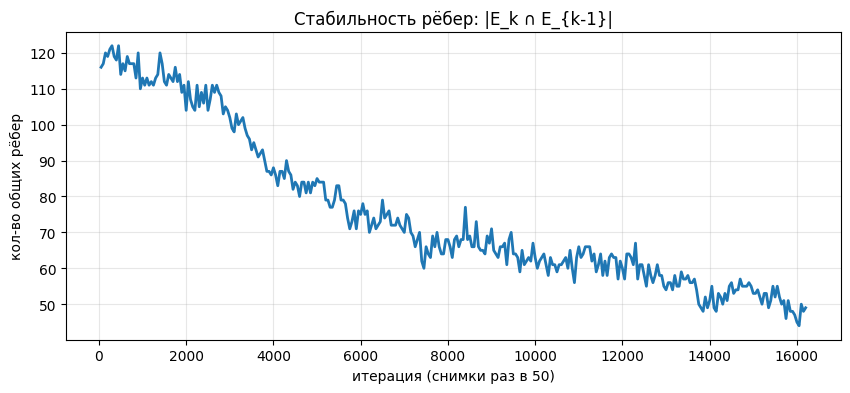

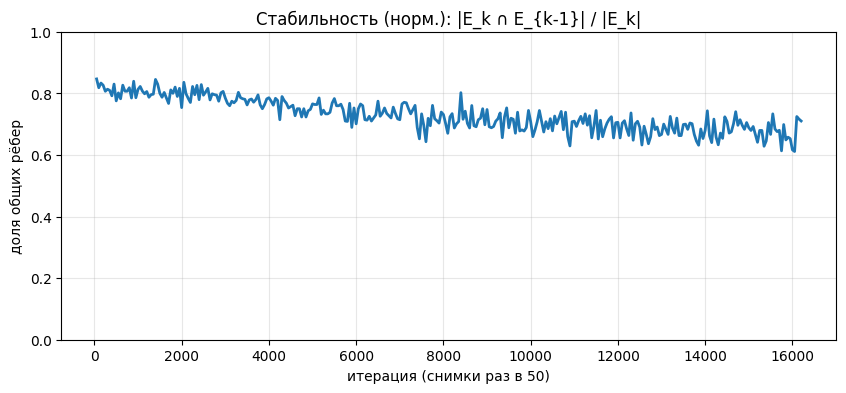

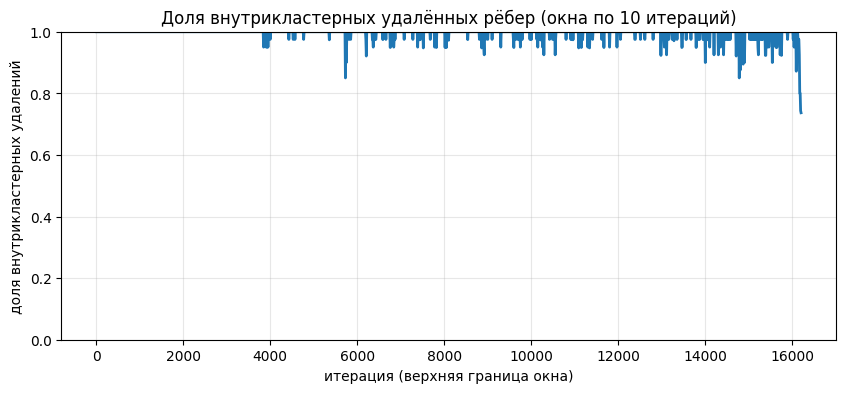

 метрика  initial  final
   edges      123     69
median_w       20     27
  mean_w       20     35
   sum_w     2438   2438


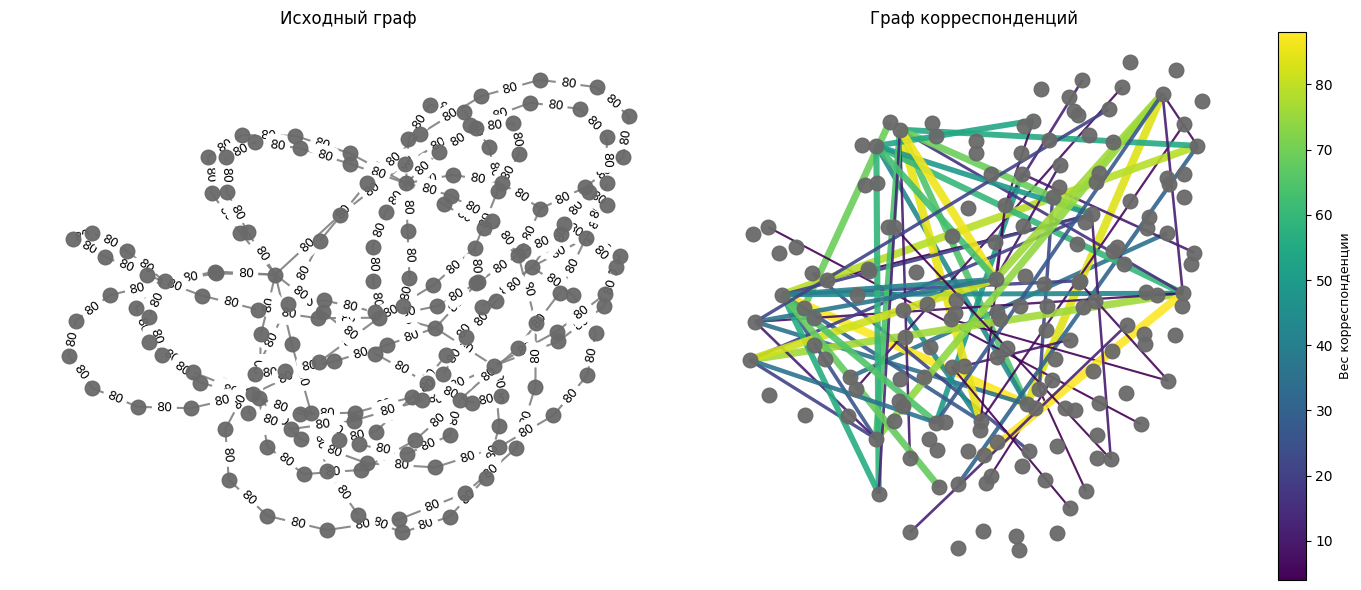

=== АНАЛИЗ (single run) ===
Время выполнения: 174.05 c
Итераций: 16200 (доля от максимума 16200 = 100.00%)
alpha_target=0.55, epsilon=0.025
initial_alpha=0.2187, final_alpha=0.2324, converged=False
Плохие шаги всего: 8138 (доля 0.50)
  — adversarial-плохих: 8138 (доля 0.50)
  — friendly-плохих:   0 (доля 0.00)


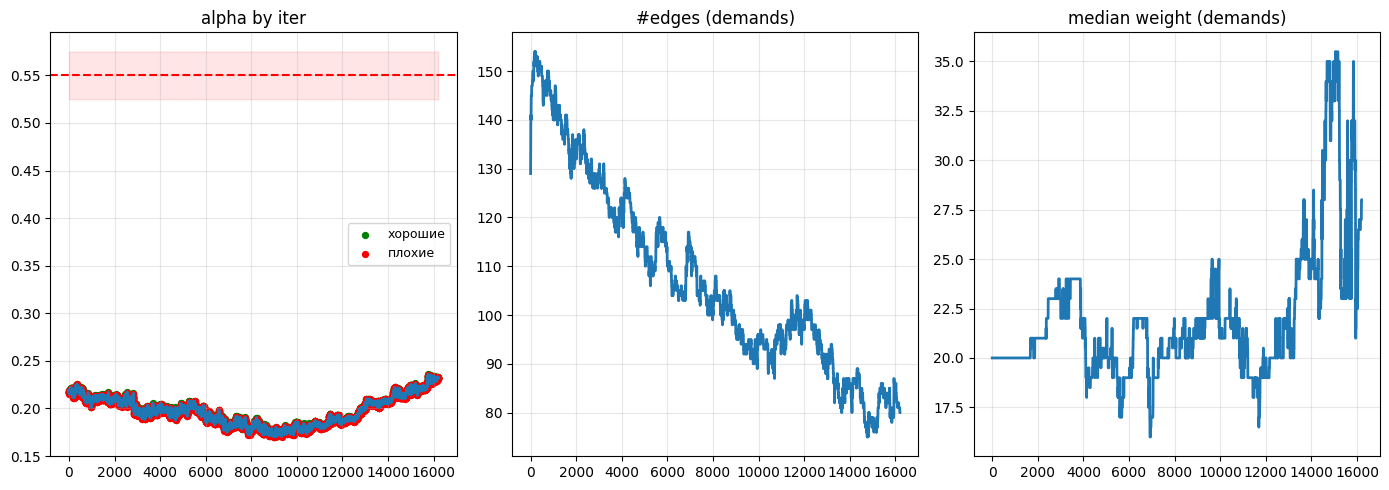

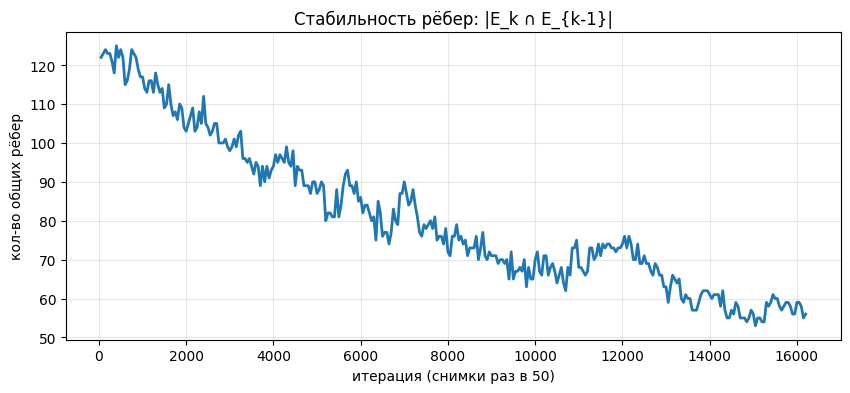

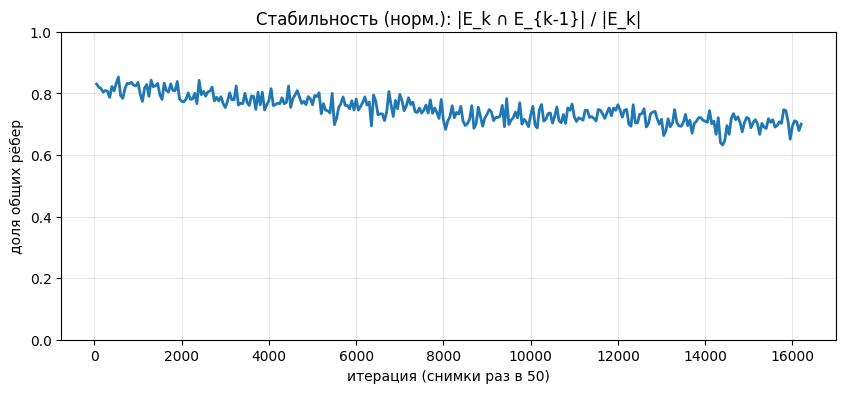

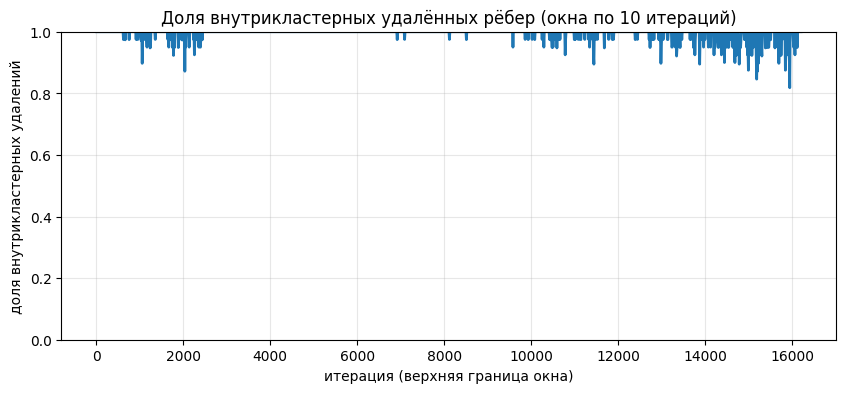

 метрика  initial  final
   edges      129     80
median_w       20     28
  mean_w       20     32
   sum_w     2572   2572


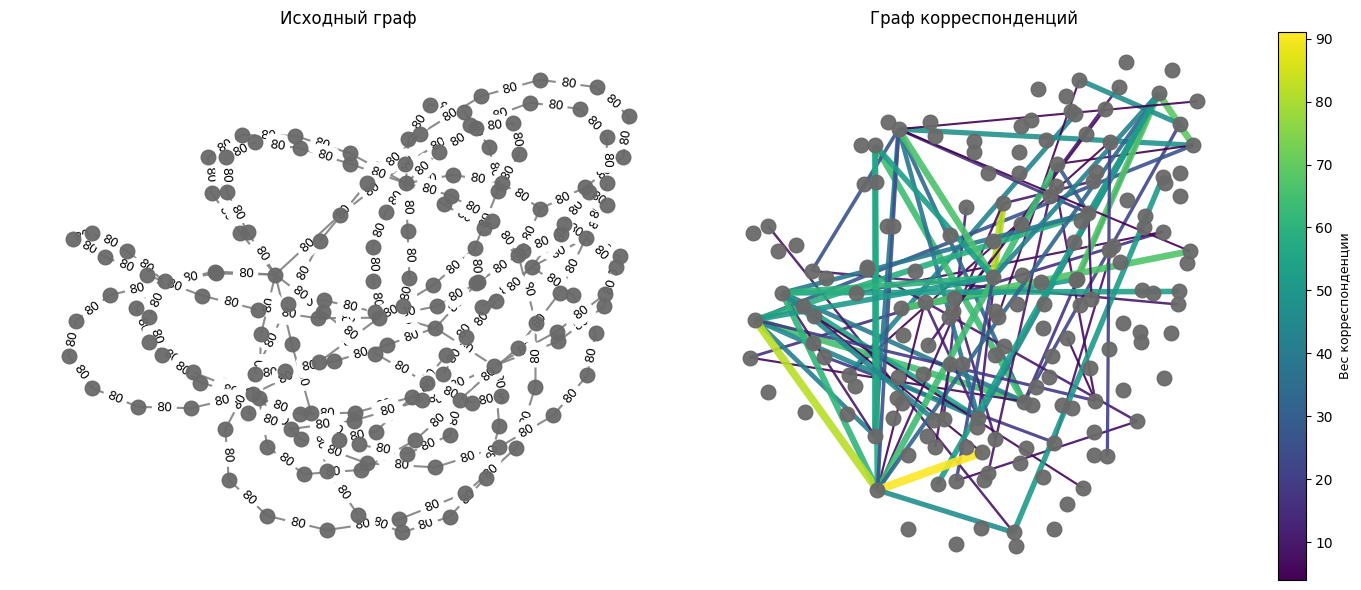

=== АНАЛИЗ (single run) ===
Время выполнения: 176.41 c
Итераций: 16200 (доля от максимума 16200 = 100.00%)
alpha_target=0.75, epsilon=0.025
initial_alpha=0.1770, final_alpha=0.2255, converged=False
Плохие шаги всего: 8087 (доля 0.50)
  — adversarial-плохих: 8087 (доля 0.50)
  — friendly-плохих:   0 (доля 0.00)


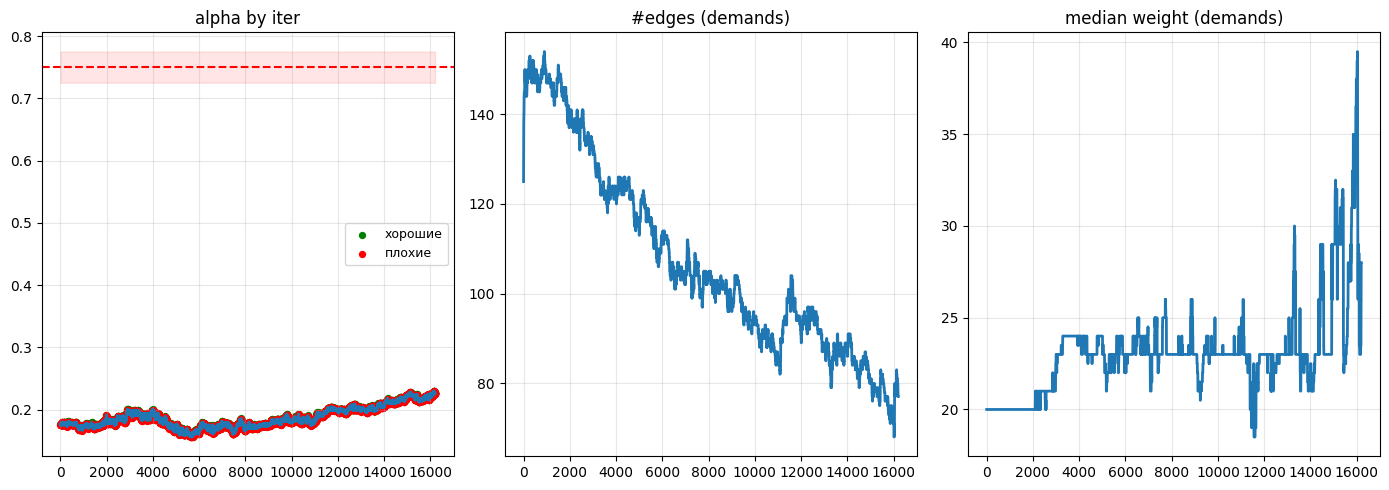

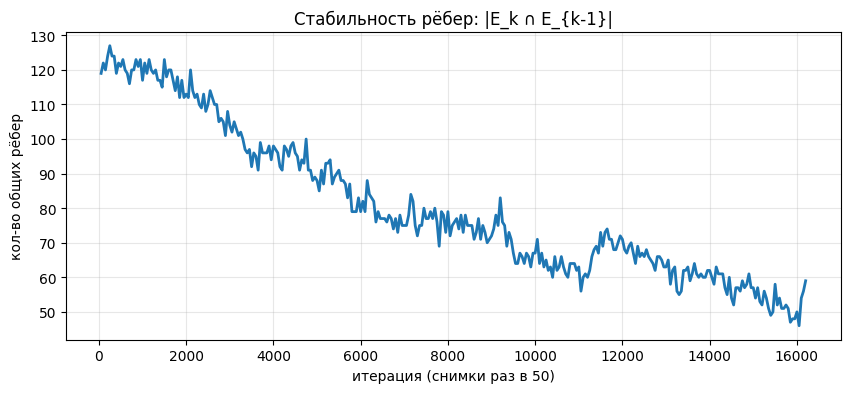

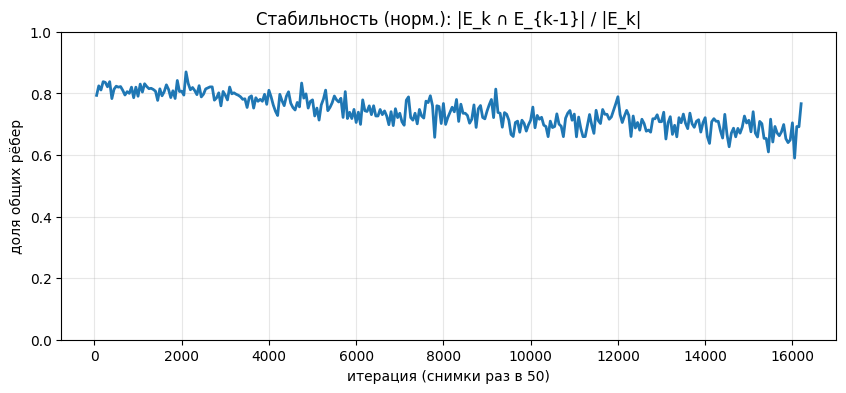

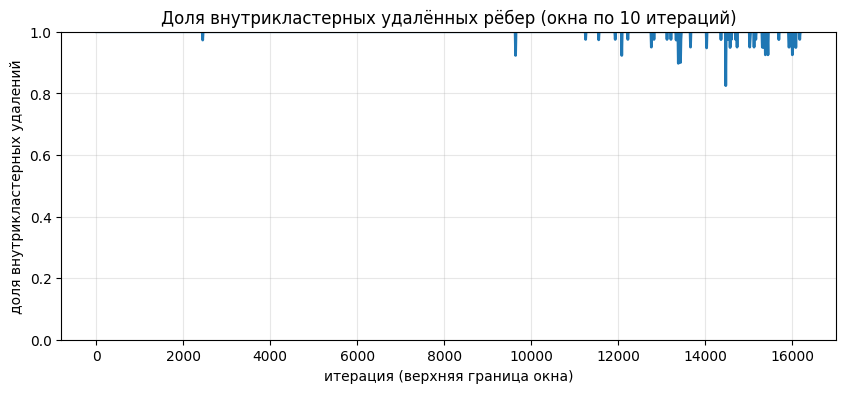

 метрика  initial  final
   edges      125     77
median_w       20     28
  mean_w       20     33
   sum_w     2512   2512


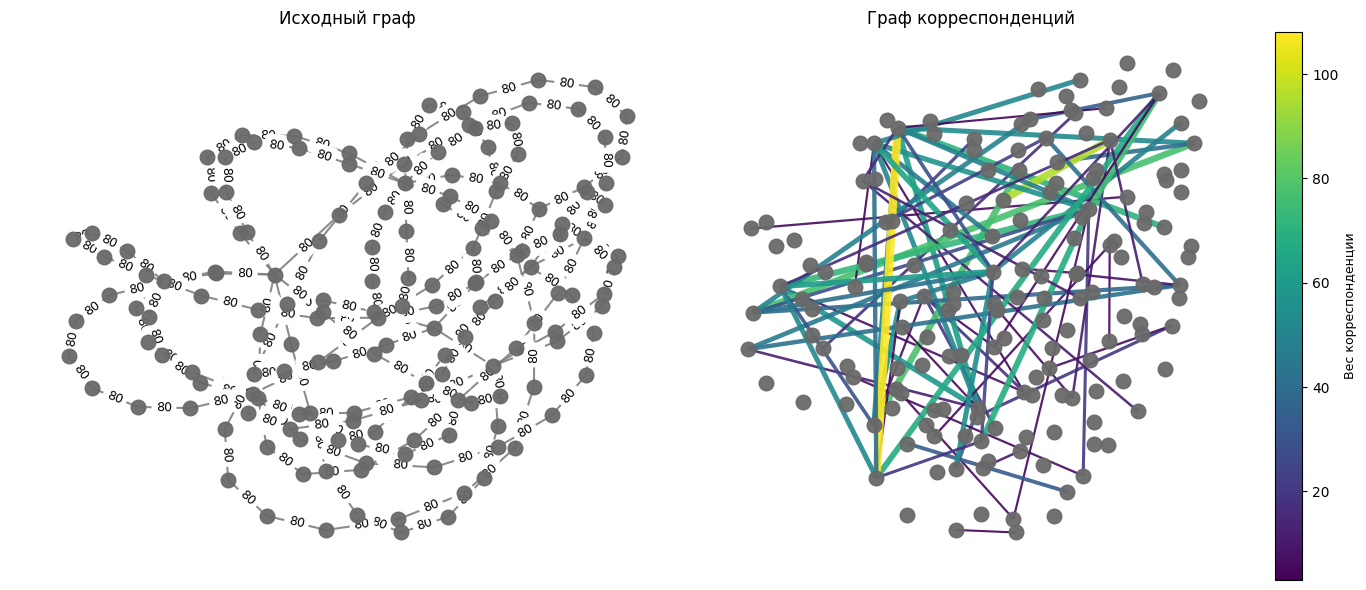

=== АНАЛИЗ (single run) ===
Время выполнения: 170.92 c
Итераций: 16200 (доля от максимума 16200 = 100.00%)
alpha_target=0.95, epsilon=0.025
initial_alpha=0.1710, final_alpha=0.2360, converged=False
Плохие шаги всего: 8030 (доля 0.50)
  — adversarial-плохих: 8030 (доля 0.50)
  — friendly-плохих:   0 (доля 0.00)


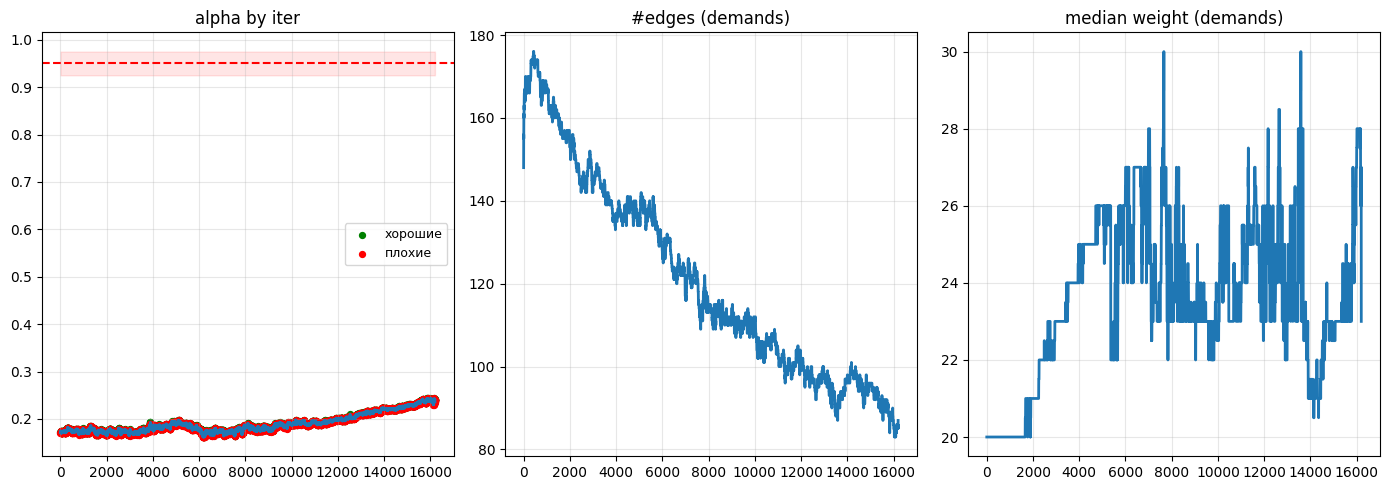

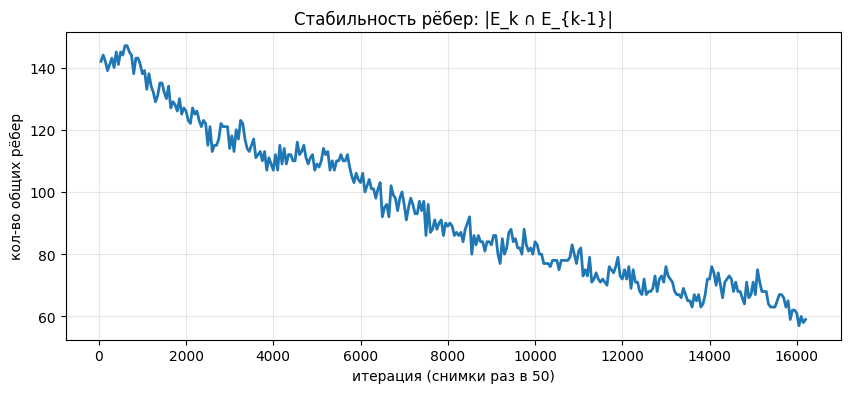

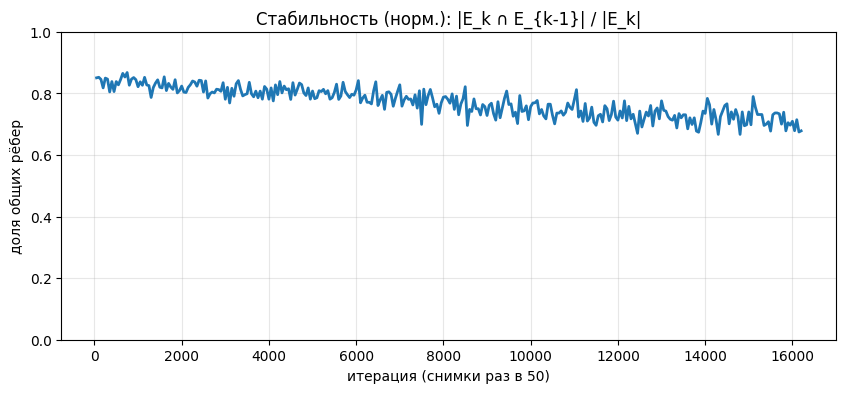

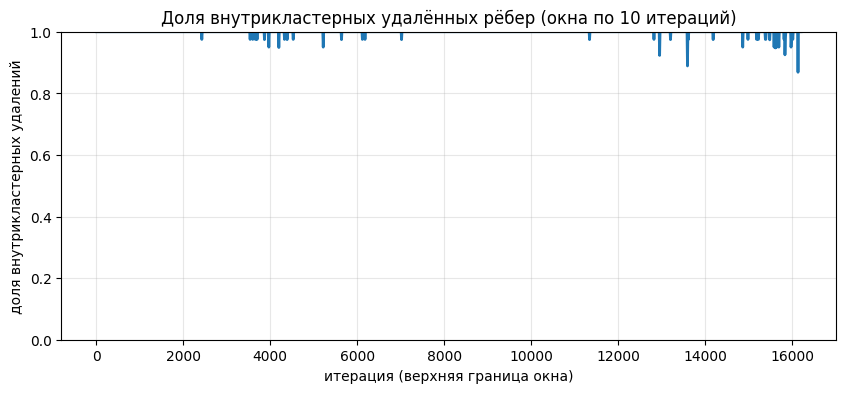

 метрика  initial  final
   edges      148     87
median_w       20     23
  mean_w       20     34
   sum_w     2955   2955


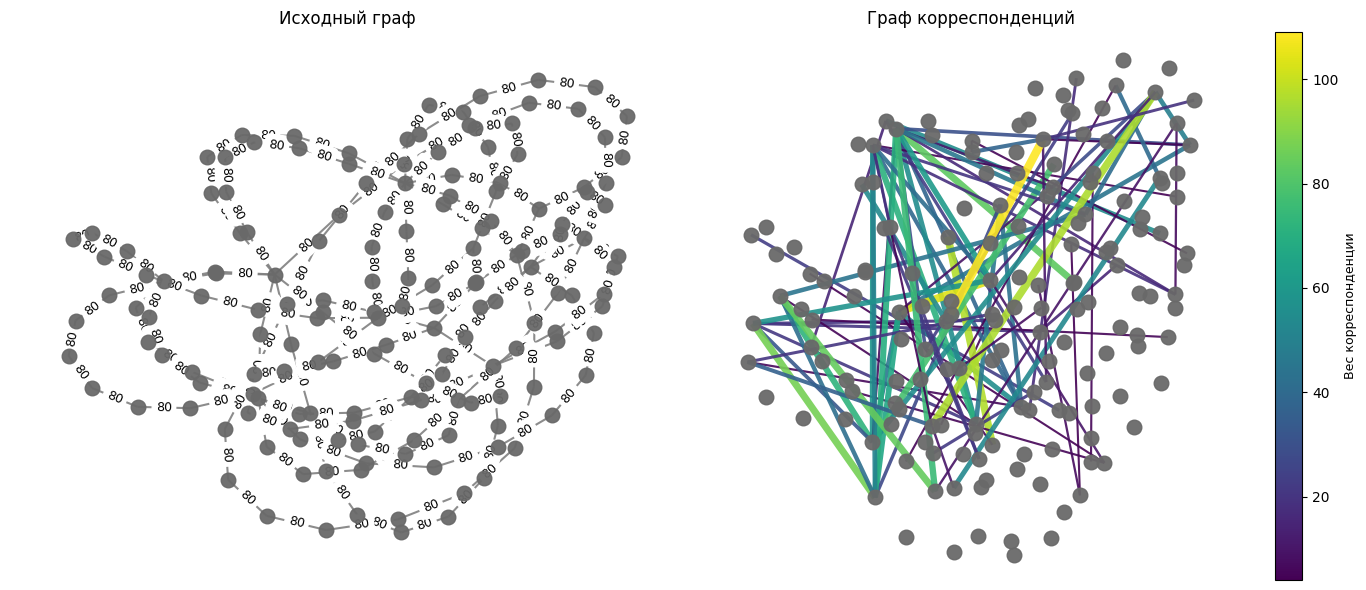



Решение MCF на итоге:
Значения gamma: alpha_target=0.15: 0.37617554830908784 alpha_target=0.35: 0.1805869074186795 alpha_target=0.55: 0.18957345969780381 alpha_target=0.75: 0.20356234075893717 alpha_target=0.95: 0.17977528081643684
Средняя загруженность ребер: alpha_target=0.15: 0.165 alpha_target=0.35: 0.160 alpha_target=0.55: 0.168 alpha_target=0.75: 0.164 alpha_target=0.95: 0.193




In [10]:
alphas_batch = [0.15, 0.35, 0.55, 0.75, 0.95]

alphas_gamma = []
alphas_workload = [] # считаем среднюю нагруженность ребер как sum(веса ребер self.demands_graph) / sum(веса ребер self.graph), так как capacity одинаковая на графах
for alpha_target in alphas_batch:
  graph_for_mcf = GraphMCF(med_graph_for_test['adj_matrix'])
  gen = MCFGeneratorMultiGraph(epsilon=0.025,
                                 p_ER = 0.01, distribution="normal", median_weight_for_initial=20, var_for_initial=5, multi_max=5,
                                 num_edges=None,)
  res = gen.generate(graph=graph_for_mcf, alpha_target=alpha_target)
  analyze_simple(graph_for_mcf, alpha_target=alpha_target, epsilon=0.025,
                 start_time=res.start_time, end_time=res.end_time,
                 alpha_history=res.alpha_history,
                 edge_counts_history=res.edge_counts_history,
                 median_weights_history=res.median_weights_history,
                 edge_mask_history=res.edge_mask_history,
                 edge_mask_snapshot_iters=res.edge_mask_snapshot_iters,
                 removal_events=res.removal_events,
                 algo_params=res.algo_params)
  graph_for_mcf.visualise_with_demands()

  sol = solve_throughput(graph_for_mcf.graph, graph_for_mcf.demands_laplacian)
  gamma = sol.gamma
  alphas_gamma.append(f"alpha_target={alpha_target}: {gamma}")

  demands_sum = sum(data['weight'] for u, v, data in graph_for_mcf.demands_graph.edges(data=True))
  capacity_sum = sum(data['weight'] for u, v, data in graph_for_mcf.graph.edges(data=True))
  workload = demands_sum / capacity_sum
  alphas_workload.append(f"alpha_target={alpha_target}: {workload:.3f}")

gamma_sequence = " ".join(alphas_gamma)
workload_sequence = " ".join(alphas_workload)
print(f"\n\nРешение MCF на итоге:\nЗначения gamma: {gamma_sequence}\nСредняя загруженность ребер: {workload_sequence}\n\n")